# Preparation

## Import of libraries

In [32]:
!pip install torchinfo > /dev/null
!pip install wandb > /dev/null

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torch.utils.checkpoint as cp
from torch.utils.data import DataLoader
from torch.jit.annotations import List

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision.transforms import Resize
from torchvision.transforms.functional_pil import resize
from torchvision.transforms import Grayscale
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.models.densenet import DenseNet

import math
import time
import os
import copy
import re

import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

from tqdm import tqdm

from torchinfo import summary
import wandb

from PIL import Image, ImageOps, ImageEnhance

## Device check

In [33]:
# Detect if we have a GPU available
!nvidia-smi

Sat Apr 30 23:18:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |   1775MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Drive

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')
'''
Update the FILE PATH before running the code!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

PATH_data = "/content/gdrive/MyDrive/INF8225/Projet_final/Dataset//"
PATH_model_baseline = "/content/gdrive/MyDrive/INF8225/Projet_final/Model/Baseline//"
PATH_model_MixUp = "/content/gdrive/MyDrive/INF8225/Projet_final/Model/MixUp//"
PATH_model_ManifoldMixUp = "/content/gdrive/MyDrive/INF8225/Projet_final/Model/ManifoldMixUp//"
PATH_model_CutMix = "/content/gdrive/MyDrive/INF8225/Projet_final/Model/CutMix//"
PATH_model_AugMix = "/content/gdrive/MyDrive/INF8225/Projet_final/Model/AugMix//"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Wandb login

In [35]:
# Checking GPU and logging to wandb
!wandb login

wandb: Currently logged in as: inf8225_ym_at (use `wandb login --relogin` to force relogin)


## Fix seeds

In [36]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data visualization

In [37]:
# DataSet
# mnist
mnist_trainset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform=ToTensor())

# CIFAR-10
CIFAR10_trainset = datasets.CIFAR10(root='./data/CIFAR', train=True, download=True, transform=ToTensor())
CIFAR10_testset = datasets.CIFAR10(root='./data/CIFAR', train=False, download=True, transform=ToTensor())

# CIFAR-100
CIFAR100_trainset = datasets.CIFAR100(root='./data/CIFAR', train=True, download=True, transform=ToTensor())
CIFAR100_testset = datasets.CIFAR100(root='./data/CIFAR', train=False, download=True, transform=ToTensor())

print('MNIST:     train - ' + str(len(mnist_trainset)) + ' test - '+ str(len(mnist_testset)))
print('CIFAR-10:  train - ' + str(len(CIFAR10_trainset)) + ' test - '+ str(len(CIFAR10_testset)))
print('CIFAR-100: train - ' + str(len(CIFAR100_trainset)) + ' test - '+ str(len(CIFAR100_testset)))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
MNIST:     train - 60000 test - 10000
CIFAR-10:  train - 50000 test - 10000
CIFAR-100: train - 50000 test - 10000


size: torch.Size([1, 28, 28])


<Figure size 432x288 with 0 Axes>

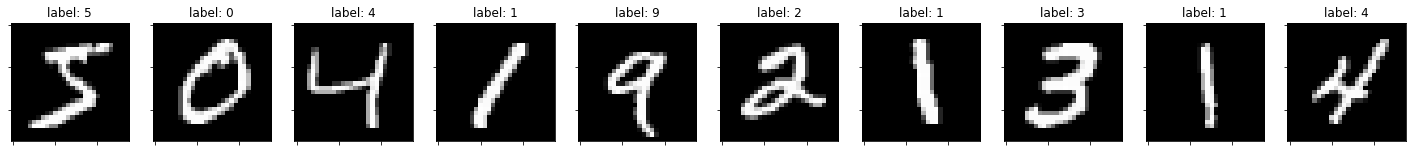

size: torch.Size([3, 32, 32])


<Figure size 432x288 with 0 Axes>

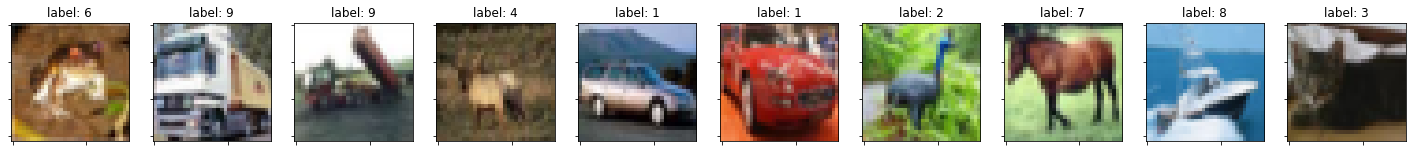

size: torch.Size([3, 32, 32])


<Figure size 432x288 with 0 Axes>

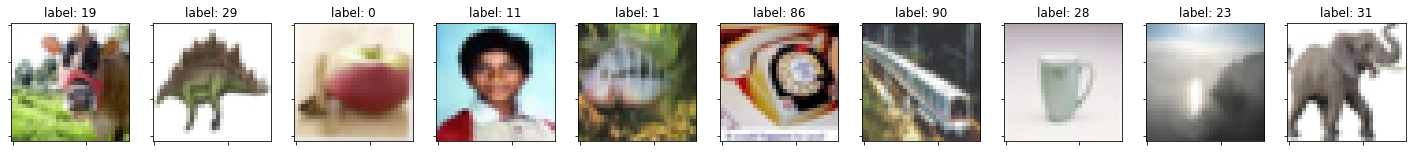

In [38]:
def imshow(dataset):
  print("size: " + str(dataset[0][0].shape))
  plt.figure()
  f,axs = plt.subplots(1,10,figsize=(25,25))
  if dataset in [mnist_trainset,mnist_testset]:
    for i in range(10):
      axs[i].imshow(dataset[i][0][0],cmap = 'gray')
      axs[i].set_title("label: " + str(dataset[i][1]))
  else:
    for i in range(10):
      axs[i].imshow((np.transpose(dataset[i][0],(1,2,0))))
      axs[i].set_title("label: " + str(dataset[i][1]))
  plt.setp([a.get_xticklabels() for a in axs[:]], visible=False) # hide x ticks
  plt.setp([a.get_yticklabels() for a in axs[:]], visible=False) # hide y ticks
  plt.show()
  

imshow(mnist_trainset)
imshow(CIFAR10_trainset)
imshow(CIFAR100_trainset)

# Normalization : Compute mean & std

In [39]:
# # DataLoader
# batch_size = 1

# mnist_trainloader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
# mnist_testloader = DataLoader(mnist_testset, batch_size=batch_size)
# CIFAR10_trainloader = DataLoader(CIFAR10_trainset, batch_size=batch_size, shuffle=True)
# CIFAR10_testloader = DataLoader(CIFAR10_testset, batch_size=batch_size)
# CIFAR100_trainloader = DataLoader(CIFAR100_trainset, batch_size=batch_size, shuffle=True)
# CIFAR100_testloader = DataLoader(CIFAR100_testset, batch_size=batch_size)

In [40]:
# # Normalization: Compute mean & std
# mean = torch.zeros(1)
# std = torch.zeros(1)
# print('==> Computing mean and std for mnist..')
# for inputs, _labels in tqdm(mnist_trainloader):
#     for i in range(1):
#         mean[i] += inputs[:,i,:,:].mean()
#         std[i] += inputs[:,i,:,:].std()
# mean.div_(len(mnist_trainset))
# std.div_(len(mnist_trainset))
# print('/n')
# print(mean, std)

# # MNIST mean: 0.1307, std: 0.3015
# mean = torch.zeros(3)
# std = torch.zeros(3)
# print('==> Computing mean and std for CIFAR-10..')
# for inputs, _labels in tqdm(CIFAR10_trainloader):
#     for i in range(3):
#         mean[i] += inputs[:,i,:,:].mean()
#         std[i] += inputs[:,i,:,:].std()
# mean.div_(len(CIFAR10_trainset))
# std.div_(len(CIFAR10_trainset))
# print('/n')
# print(mean, std)

# # CIFAR-10 mean: ([0.4914, 0.4822, 0.4465]) std: ([0.2023, 0.1994, 0.2010])
# mean = torch.zeros(3)
# std = torch.zeros(3)
# print('==> Computing mean and std for CIFAR-100..')
# for inputs, _labels in tqdm(CIFAR100_trainloader):
#     for i in range(3):
#         mean[i] += inputs[:,i,:,:].mean()
#         std[i] += inputs[:,i,:,:].std()
# mean.div_(len(CIFAR100_trainset))
# std.div_(len(CIFAR100_trainset))
# print('/n')
# print(mean, std)

# ResNet18

In [41]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.num_classes = num_classes
        self.linear = nn.Linear(512*block.expansion, self.num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# DenseNet121

In [42]:
'''DenseNet in PyTorch.'''

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_classes = num_classes

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, self.num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x, lam = None, target = None, num_classes = None):

        out = self.conv1(x)
        out = self.trans1(self.dense1(out))

        out = self.trans2(self.dense2(out))

        out = self.trans3(self.dense3(out))

        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def DenseNet121(num_classes):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, num_classes = num_classes)

# Basic parameters - Config

In [43]:
batch_size = 128
epochs = 10000 #10000
lr = 0.001

config = {
    'model_name' : 'resnet',
    'dataset_name' : 'CIFAR10', # mnist CIFAR10 CIFAR100
    'batch_size' : 128,
    'lr': 1e-1,
    'weight_decay': 1e-4,
    'IMAGE_SIZE' : 32, # 28 or 32
    'epochs' : 200, #10000
    'num_classes' : 10, # mnist: 10, cifar-10: 10, cifar-100: 100
    'feature_extract' : False,
    # 'seed': 0,
    'log_every': 50,
    'mixup_alpha' : 1,
    'augmentations': True,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'DAmethod': 'Baseline' # Baseline MixUp ManifoldMixUp CutMix AugMix

}

device = config['device']

# Training process - Mixup, CutMix, AugMix

In [44]:
def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = config['lr']
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_model(model, trainloader, testloader, criterion, optimizer, scheduler, DAmethod, datasetname, num_epochs=25, jsd_loss = False):

  if DAmethod == "Baseline":
    savepath = PATH_model_baseline
  elif DAmethod == "MixUp":
    savepath = PATH_model_MixUp
  elif DAmethod == "ManifoldMixUp":
    savepath = PATH_model_ManifoldMixUp
  elif DAmethod == "CutMix":
    savepath = PATH_model_CutMix  
  elif DAmethod == "AugMix":
    savepath = PATH_model_AugMix

  since = time.time()
  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  earlystopping = 0.
  loss_ema = 0.

  device = config['device']

  for epoch in range(num_epochs):

    if earlystopping < 2000:

      print('Epoch {}/{}'.format(epoch+1, num_epochs))
      print('-' * 10)
      # Each epoch has a training and validation phase
      for phase in ['train', 'valid']:
        if phase == 'train':
          model.train()  # Set model to training mode

          running_loss = 0.0
          running_corrects = 0

          for batch_idx,(inputs, labels) in tqdm(enumerate(trainloader)): # for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()

            if jsd_loss:
              inputs_all = torch.cat(inputs,0).to(device)
              labels = labels.to(device)
              outputs_all = model(inputs_all)
              outputs_clean,outputs_aug1,outputs_aug2 = torch.split(
                  outputs_all, inputs[0].size(0)
              )
              _, preds = torch.max(outputs_clean, 1)

              loss = F.cross_entropy(outputs_clean,labels)

              p_clean = F.softmax(outputs_clean,dim=1)
              p_aug1 = F.softmax(outputs_aug1,dim=1)
              p_aug2 = F.softmax(outputs_aug2,dim=1)

              p_mixture = torch.clamp((p_clean+p_aug1+p_aug2)/3.,1e-7,1).log()

              loss += 12 * (F.kl_div(p_mixture, p_clean, reduction = 'batchmean') +
                       F.kl_div(p_mixture, p_aug1, reduction = 'batchmean') +
                       F.kl_div(p_mixture, p_aug2, reduction = 'batchmean')) / 3.

            elif DAmethod == 'MixUp':
              inputs = inputs.to(device)
              labels = labels.to(device) 
              inputs, labels, second_labels, lam = mixup(inputs, labels, config['mixup_alpha'])
              outputs = model(inputs)
              loss = mixup_criterion(criterion, outputs, labels, second_labels, lam)
              _, preds = torch.max(outputs, 1)
              
            elif DAmethod == 'CutMix':
              inputs = inputs.to(device)
              labels = labels.to(device) 
              inputs, labels, second_labels, lam = cutmix(inputs, labels, config['mixup_alpha'])
              outputs = model(inputs)
              loss = mixup_criterion(criterion, outputs, labels, second_labels, lam)
              _, preds = torch.max(outputs, 1)

            else:
              inputs = inputs.to(device)
              labels = labels.to(device) 
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              _, preds = torch.max(outputs, 1)
            
            loss.backward()
            optimizer.step()
            

            if batch_idx % config['log_every'] == 0:
              if jsd_loss:
                train_logs = {
                    f'Train - jsd_loss': loss_ema
                }
                wandb.log(train_logs)
              else:
                train_logs = {
                    f'Train - loss': loss.item()
                }
                wandb.log(train_logs)


            if jsd_loss:
              loss_ema = loss_ema * 0.9 + float(loss) * 0.1
              running_loss += loss_ema * inputs[0].size(0)
            else:
              running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(trainloader.dataset)
          epoch_acc = running_corrects.double() / len(trainloader.dataset)
          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
          wandb.log({'Train - acc': epoch_acc})
        else:
          model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              _, preds = torch.max(outputs, 1)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(testloader.dataset)
            epoch_acc = running_corrects.double() / len(testloader.dataset)
          wandb.log({'Valid - loss': epoch_loss})
          wandb.log({'Valid - acc': epoch_acc})

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

          if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

            checkpoint = {
                'epoch': epoch,
                'trainloader': trainloader,
                'testloader': testloader,
                'model': model,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                }
            earlystopping = 0

            checkpoint_path = savepath + '{}_{}_checkpoint.pth.tar'.format(datasetname,DAmethod)
            print("Saving model...")
            torch.save(checkpoint, checkpoint_path)
          else:
            earlystopping += 1

          print('-' * 30 + '\n')
          val_acc_history.append(epoch_acc)
    # for earlystopping
    # else:
    #   best_path = savepath + '{}_{}_best_model_{}.pth.tar'.format(datasetname, DAmethod, best_acc)
    #   torch.save(checkpoint, best_path)
    #   print("Best model saved.")
    #   break
    if scheduler:
      scheduler.step()
    else:    
      adjust_learning_rate(optimizer, epoch)

  # for 200 epochs
  best_path = savepath + '{}_{}_best_model_{}.pth.tar'.format(datasetname, DAmethod, best_acc)
  torch.save(checkpoint, best_path)
  print("Best model saved.")
      
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

def initialize_model(model_name, dataset_name, feature_extract=False, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if dataset_name == "mnist":
      input_size = 28
      num_classes = 10
    elif dataset_name =="cifar10":
      input_size = 32
      num_classes = 10
    else:
      input_size = 32
      num_classes = 100

    if model_name == "resnet":
        """ 
        Resnet18
        """
        model_ft = ResNet18(num_classes)

    elif model_name == "densenet":
        """ 
        Densenet
        """
        model_ft = DenseNet121(num_classes)


    return model_ft, input_size

# Preprocessing

In [45]:
# DataSet
# mnist
mnist_trainset = datasets.MNIST(root='./data/MNIST', train=True, download=True)
mnist_trainset.transform = transforms.Compose([
               Grayscale(num_output_channels=3),
               ToTensor(),
               Normalize([0.1307],[0.3015]),
    ])
mnist_testset = datasets.MNIST(root='./data/MNIST', train=False, download=True)
mnist_testset.transform = transforms.Compose([
               Grayscale(num_output_channels=3),
               ToTensor(),
               Normalize([0.1307],[0.3015]),
    ])

# CIFAR-10
CIFAR10_trainset = datasets.CIFAR10(root='./data/CIFAR', train=True, download=True)
CIFAR10_trainset.transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(32, padding=4),
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
    ])
CIFAR10_testset = datasets.CIFAR10(root='./data/CIFAR', train=False, download=True)
CIFAR10_testset.transform = transforms.Compose([
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
    ])

# CIFAR-100
CIFAR100_trainset = datasets.CIFAR100(root='./data/CIFAR', train=True, download=True)
CIFAR100_trainset.transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(32, padding=4),
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
    ])
CIFAR100_testset = datasets.CIFAR100(root='./data/CIFAR', train=False, download=True)
CIFAR100_testset.transform = transforms.Compose([
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
    ])


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Dataloader

In [46]:
mnist_trainloader = DataLoader(mnist_trainset, batch_size=config['batch_size'], shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=config['batch_size'])
CIFAR10_trainloader = DataLoader(CIFAR10_trainset, batch_size=config['batch_size'], shuffle=True)
CIFAR10_testloader = DataLoader(CIFAR10_testset, batch_size=config['batch_size'])
CIFAR100_trainloader = DataLoader(CIFAR100_trainset, batch_size=config['batch_size'], shuffle=True)
CIFAR100_testloader = DataLoader(CIFAR100_testset, batch_size=config['batch_size'])

size: torch.Size([3, 28, 28])


<Figure size 432x288 with 0 Axes>

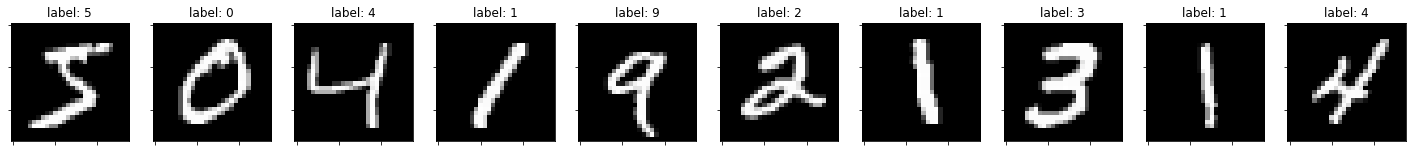

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

size: torch.Size([3, 32, 32])


<Figure size 432x288 with 0 Axes>

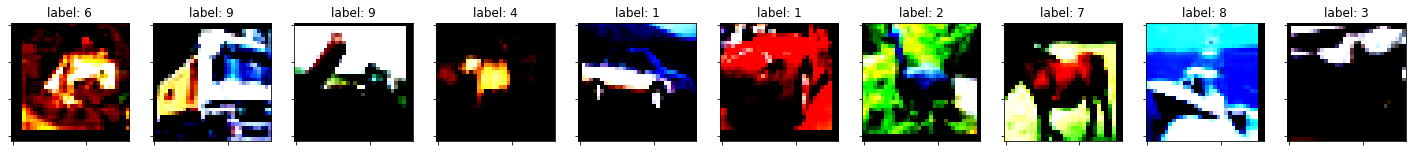

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

size: torch.Size([3, 32, 32])


<Figure size 432x288 with 0 Axes>

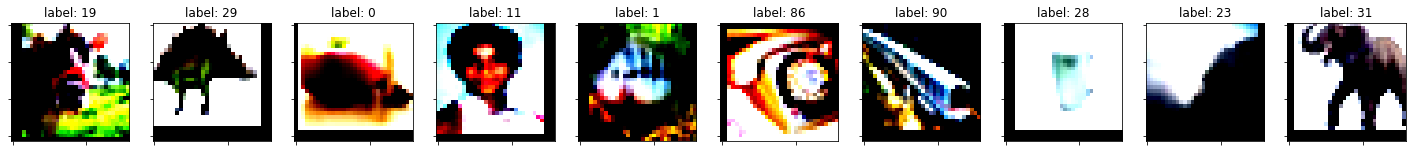

In [47]:
imshow(mnist_trainloader.dataset)
imshow(CIFAR10_trainloader.dataset)
imshow(CIFAR100_trainloader.dataset)

# Baseline

## Model training

### ResNet18

#### mnist

In [48]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'mnist' # mnist cifar10 cifar100

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

!wandb online  # online / offline to activate or deactivate WandB logging

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_mnist_Baseline',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, mnist_trainloader, mnist_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod= "Baseline", datasetname = config['dataset_name'])

#### cifar10

In [50]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'cifar10' # mnist cifar10 cifar100


In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_cifar10_Baseline',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'Baseline', datasetname = config['dataset_name'])

#### cifar100

In [52]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'cifar100' # mnist cifar10 cifar100

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_cifar100_Baseline',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'Baseline', datasetname = config['dataset_name'])

### DenseNet121

#### cifar10

In [58]:
config['model_name'] = 'densenet'
config['dataset_name'] = 'cifar10' # mnist cifar10 cifar100


In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'densenet121_cifar10_Baseline',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'Baseline', datasetname = config['dataset_name'])

#### cifar100

In [60]:
config['model_name'] = 'densenet'
config['dataset_name'] = 'cifar100' # mnist cifar10 cifar100


In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'densenet121_cifar100_Baseline',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'Baseline', datasetname = config['dataset_name'])

wandb: Currently logged in as: inf8225_ym_at (use `wandb login --relogin` to force relogin)


Epoch 1/200
----------


391it [02:04,  3.15it/s]


train Loss: 3.8027 Acc: 0.1110
valid Loss: 3.3873 Acc: 0.1753
Saving model...
------------------------------

Epoch 2/200
----------


391it [02:04,  3.15it/s]


train Loss: 3.0025 Acc: 0.2446
valid Loss: 2.6761 Acc: 0.3081
Saving model...
------------------------------

Epoch 3/200
----------


391it [02:03,  3.16it/s]


train Loss: 2.3505 Acc: 0.3740
valid Loss: 2.3683 Acc: 0.3751
Saving model...
------------------------------

Epoch 4/200
----------


391it [02:04,  3.15it/s]


train Loss: 1.9878 Acc: 0.4540
valid Loss: 2.3584 Acc: 0.3995
Saving model...
------------------------------

Epoch 5/200
----------


391it [02:04,  3.15it/s]


train Loss: 1.7779 Acc: 0.5042
valid Loss: 1.9008 Acc: 0.4789
Saving model...
------------------------------

Epoch 6/200
----------


391it [02:04,  3.15it/s]


train Loss: 1.6372 Acc: 0.5386
valid Loss: 1.8464 Acc: 0.4965
Saving model...
------------------------------

Epoch 7/200
----------


391it [02:03,  3.16it/s]


train Loss: 1.5251 Acc: 0.5702
valid Loss: 1.9612 Acc: 0.4728
------------------------------

Epoch 8/200
----------


391it [02:03,  3.16it/s]


train Loss: 1.4367 Acc: 0.5886
valid Loss: 1.7505 Acc: 0.5215
Saving model...
------------------------------

Epoch 9/200
----------


391it [02:03,  3.15it/s]


train Loss: 1.3663 Acc: 0.6062
valid Loss: 1.6959 Acc: 0.5359
Saving model...
------------------------------

Epoch 10/200
----------


391it [02:03,  3.16it/s]


train Loss: 1.3067 Acc: 0.6223
valid Loss: 1.5375 Acc: 0.5742
Saving model...
------------------------------

Epoch 11/200
----------


391it [02:03,  3.16it/s]


train Loss: 1.2501 Acc: 0.6379
valid Loss: 1.7467 Acc: 0.5424
------------------------------

Epoch 12/200
----------


391it [02:03,  3.17it/s]


train Loss: 1.2140 Acc: 0.6479
valid Loss: 1.5313 Acc: 0.5753
Saving model...
------------------------------

Epoch 13/200
----------


391it [02:03,  3.16it/s]


train Loss: 1.1639 Acc: 0.6581
valid Loss: 1.5385 Acc: 0.5819
Saving model...
------------------------------

Epoch 14/200
----------


391it [02:03,  3.15it/s]


train Loss: 1.1361 Acc: 0.6683
valid Loss: 1.5389 Acc: 0.5755
------------------------------

Epoch 15/200
----------


391it [02:03,  3.16it/s]


train Loss: 1.1043 Acc: 0.6747
valid Loss: 1.6377 Acc: 0.5612
------------------------------

Epoch 16/200
----------


391it [02:03,  3.17it/s]


train Loss: 1.0809 Acc: 0.6830
valid Loss: 1.5182 Acc: 0.5896
Saving model...
------------------------------

Epoch 17/200
----------


391it [02:03,  3.17it/s]


train Loss: 1.0443 Acc: 0.6922
valid Loss: 1.5057 Acc: 0.5979
Saving model...
------------------------------

Epoch 18/200
----------


391it [02:03,  3.17it/s]


train Loss: 1.0148 Acc: 0.6999
valid Loss: 1.4991 Acc: 0.5927
------------------------------

Epoch 19/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.9794 Acc: 0.7098
valid Loss: 1.5171 Acc: 0.5916
------------------------------

Epoch 20/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.9563 Acc: 0.7140
valid Loss: 1.3812 Acc: 0.6210
Saving model...
------------------------------

Epoch 21/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.9291 Acc: 0.7224
valid Loss: 1.3812 Acc: 0.6208
------------------------------

Epoch 22/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.9053 Acc: 0.7284
valid Loss: 1.3443 Acc: 0.6265
Saving model...
------------------------------

Epoch 23/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.8707 Acc: 0.7396
valid Loss: 1.4310 Acc: 0.6097
------------------------------

Epoch 24/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.8469 Acc: 0.7460
valid Loss: 1.3455 Acc: 0.6377
Saving model...
------------------------------

Epoch 25/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.8185 Acc: 0.7554
valid Loss: 1.4022 Acc: 0.6243
------------------------------

Epoch 26/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.7839 Acc: 0.7649
valid Loss: 1.4451 Acc: 0.6189
------------------------------

Epoch 27/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.7630 Acc: 0.7686
valid Loss: 1.2905 Acc: 0.6528
Saving model...
------------------------------

Epoch 28/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.7264 Acc: 0.7788
valid Loss: 1.3257 Acc: 0.6431
------------------------------

Epoch 29/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.7046 Acc: 0.7851
valid Loss: 1.3037 Acc: 0.6474
------------------------------

Epoch 30/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.6625 Acc: 0.7981
valid Loss: 1.2260 Acc: 0.6675
Saving model...
------------------------------

Epoch 31/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.6425 Acc: 0.8034
valid Loss: 1.2429 Acc: 0.6699
Saving model...
------------------------------

Epoch 32/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.5991 Acc: 0.8142
valid Loss: 1.2957 Acc: 0.6629
------------------------------

Epoch 33/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.5639 Acc: 0.8257
valid Loss: 1.2166 Acc: 0.6696
------------------------------

Epoch 34/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.5312 Acc: 0.8347
valid Loss: 1.1585 Acc: 0.6860
Saving model...
------------------------------

Epoch 35/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.4988 Acc: 0.8452
valid Loss: 1.1958 Acc: 0.6813
------------------------------

Epoch 36/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.4627 Acc: 0.8557
valid Loss: 1.1289 Acc: 0.7039
Saving model...
------------------------------

Epoch 37/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.4214 Acc: 0.8685
valid Loss: 1.2255 Acc: 0.6823
------------------------------

Epoch 38/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.3842 Acc: 0.8812
valid Loss: 1.1207 Acc: 0.6989
------------------------------

Epoch 39/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.3447 Acc: 0.8932
valid Loss: 1.1252 Acc: 0.7011
------------------------------

Epoch 40/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.2983 Acc: 0.9080
valid Loss: 1.0698 Acc: 0.7174
Saving model...
------------------------------

Epoch 41/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.2666 Acc: 0.9204
valid Loss: 1.1394 Acc: 0.7079
------------------------------

Epoch 42/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.2194 Acc: 0.9358
valid Loss: 1.1377 Acc: 0.7150
------------------------------

Epoch 43/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.1863 Acc: 0.9457
valid Loss: 1.0555 Acc: 0.7362
Saving model...
------------------------------

Epoch 44/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.1528 Acc: 0.9576
valid Loss: 1.0189 Acc: 0.7439
Saving model...
------------------------------

Epoch 45/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.1121 Acc: 0.9713
valid Loss: 0.9851 Acc: 0.7567
Saving model...
------------------------------

Epoch 46/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0843 Acc: 0.9800
valid Loss: 0.9795 Acc: 0.7539
------------------------------

Epoch 47/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0630 Acc: 0.9862
valid Loss: 0.9748 Acc: 0.7638
Saving model...
------------------------------

Epoch 48/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0477 Acc: 0.9907
valid Loss: 0.9321 Acc: 0.7700
Saving model...
------------------------------

Epoch 49/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0348 Acc: 0.9941
valid Loss: 0.9229 Acc: 0.7751
Saving model...
------------------------------

Epoch 50/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0271 Acc: 0.9966
valid Loss: 0.9059 Acc: 0.7802
Saving model...
------------------------------

Epoch 51/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0206 Acc: 0.9975
valid Loss: 0.8823 Acc: 0.7849
Saving model...
------------------------------

Epoch 52/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0174 Acc: 0.9983
valid Loss: 0.8772 Acc: 0.7854
Saving model...
------------------------------

Epoch 53/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0148 Acc: 0.9988
valid Loss: 0.8757 Acc: 0.7852
------------------------------

Epoch 54/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0132 Acc: 0.9990
valid Loss: 0.8710 Acc: 0.7867
Saving model...
------------------------------

Epoch 55/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0129 Acc: 0.9989
valid Loss: 0.8733 Acc: 0.7860
------------------------------

Epoch 56/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0118 Acc: 0.9992
valid Loss: 0.8702 Acc: 0.7876
Saving model...
------------------------------

Epoch 57/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0112 Acc: 0.9994
valid Loss: 0.8679 Acc: 0.7890
Saving model...
------------------------------

Epoch 58/200
----------


391it [02:03,  3.16it/s]


train Loss: 0.0110 Acc: 0.9993
valid Loss: 0.8665 Acc: 0.7879
------------------------------

Epoch 59/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0104 Acc: 0.9997
valid Loss: 0.8718 Acc: 0.7878
------------------------------

Epoch 60/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0106 Acc: 0.9994
valid Loss: 0.8643 Acc: 0.7879
------------------------------

Epoch 61/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0103 Acc: 0.9994
valid Loss: 0.8689 Acc: 0.7872
------------------------------

Epoch 62/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0108 Acc: 0.9993
valid Loss: 0.8689 Acc: 0.7887
------------------------------

Epoch 63/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0105 Acc: 0.9995
valid Loss: 0.8685 Acc: 0.7880
------------------------------

Epoch 64/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0107 Acc: 0.9995
valid Loss: 0.8705 Acc: 0.7858
------------------------------

Epoch 65/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0103 Acc: 0.9993
valid Loss: 0.8702 Acc: 0.7880
------------------------------

Epoch 66/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0106 Acc: 0.9993
valid Loss: 0.8705 Acc: 0.7874
------------------------------

Epoch 67/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0111 Acc: 0.9992
valid Loss: 0.8713 Acc: 0.7886
------------------------------

Epoch 68/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0111 Acc: 0.9993
valid Loss: 0.8779 Acc: 0.7886
------------------------------

Epoch 69/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0118 Acc: 0.9991
valid Loss: 0.8703 Acc: 0.7875
------------------------------

Epoch 70/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0128 Acc: 0.9990
valid Loss: 0.8912 Acc: 0.7871
------------------------------

Epoch 71/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0146 Acc: 0.9986
valid Loss: 0.8973 Acc: 0.7848
------------------------------

Epoch 72/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.0173 Acc: 0.9981
valid Loss: 0.9197 Acc: 0.7773
------------------------------

Epoch 73/200
----------


391it [02:02,  3.18it/s]


train Loss: 0.0295 Acc: 0.9960
valid Loss: 0.9384 Acc: 0.7721
------------------------------

Epoch 74/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.0792 Acc: 0.9819
valid Loss: 1.0921 Acc: 0.7294
------------------------------

Epoch 75/200
----------


391it [02:03,  3.18it/s]


train Loss: 0.1807 Acc: 0.9502
valid Loss: 1.1171 Acc: 0.7179
------------------------------

Epoch 76/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.2625 Acc: 0.9238
valid Loss: 1.1909 Acc: 0.6925
------------------------------

Epoch 77/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.3215 Acc: 0.9036
valid Loss: 1.2249 Acc: 0.6951
------------------------------

Epoch 78/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.3679 Acc: 0.8882
valid Loss: 1.2276 Acc: 0.6809
------------------------------

Epoch 79/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.4016 Acc: 0.8774
valid Loss: 1.2257 Acc: 0.6824
------------------------------

Epoch 80/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.4162 Acc: 0.8704
valid Loss: 1.3356 Acc: 0.6620
------------------------------

Epoch 81/200
----------


391it [02:03,  3.17it/s]


train Loss: 0.4447 Acc: 0.8613
valid Loss: 1.2827 Acc: 0.6713
------------------------------

Epoch 82/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.4659 Acc: 0.8551
valid Loss: 1.3585 Acc: 0.6639
------------------------------

Epoch 83/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.4562 Acc: 0.8573
valid Loss: 1.2610 Acc: 0.6763
------------------------------

Epoch 84/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.4686 Acc: 0.8532
valid Loss: 1.2879 Acc: 0.6751
------------------------------

Epoch 85/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.4936 Acc: 0.8470
valid Loss: 1.3619 Acc: 0.6683
------------------------------

Epoch 86/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5030 Acc: 0.8429
valid Loss: 1.2800 Acc: 0.6667
------------------------------

Epoch 87/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5207 Acc: 0.8365
valid Loss: 1.4398 Acc: 0.6420
------------------------------

Epoch 88/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5361 Acc: 0.8330
valid Loss: 1.3094 Acc: 0.6641
------------------------------

Epoch 89/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5486 Acc: 0.8291
valid Loss: 1.3890 Acc: 0.6451
------------------------------

Epoch 90/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5555 Acc: 0.8299
valid Loss: 1.2256 Acc: 0.6791
------------------------------

Epoch 91/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5665 Acc: 0.8253
valid Loss: 1.3550 Acc: 0.6533
------------------------------

Epoch 92/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5913 Acc: 0.8169
valid Loss: 1.3162 Acc: 0.6592
------------------------------

Epoch 93/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.5973 Acc: 0.8153
valid Loss: 1.3614 Acc: 0.6415
------------------------------

Epoch 94/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.6287 Acc: 0.8068
valid Loss: 1.3308 Acc: 0.6545
------------------------------

Epoch 95/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.6310 Acc: 0.8068
valid Loss: 1.3494 Acc: 0.6451
------------------------------

Epoch 96/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.6511 Acc: 0.8000
valid Loss: 1.4716 Acc: 0.6264
------------------------------

Epoch 97/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.6593 Acc: 0.7968
valid Loss: 1.4166 Acc: 0.6307
------------------------------

Epoch 98/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.6755 Acc: 0.7933
valid Loss: 1.3636 Acc: 0.6420
------------------------------

Epoch 99/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.6883 Acc: 0.7895
valid Loss: 1.3799 Acc: 0.6427
------------------------------

Epoch 100/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7026 Acc: 0.7862
valid Loss: 1.3661 Acc: 0.6427
------------------------------

Epoch 101/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7254 Acc: 0.7796
valid Loss: 1.3593 Acc: 0.6360
------------------------------

Epoch 102/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7285 Acc: 0.7777
valid Loss: 1.4193 Acc: 0.6353
------------------------------

Epoch 103/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7427 Acc: 0.7760
valid Loss: 1.5677 Acc: 0.6108
------------------------------

Epoch 104/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7647 Acc: 0.7689
valid Loss: 1.6291 Acc: 0.5841
------------------------------

Epoch 105/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7674 Acc: 0.7700
valid Loss: 1.4049 Acc: 0.6261
------------------------------

Epoch 106/200
----------


391it [02:04,  3.13it/s]


train Loss: 0.7795 Acc: 0.7633
valid Loss: 1.4403 Acc: 0.6224
------------------------------

Epoch 107/200
----------


391it [02:04,  3.13it/s]


train Loss: 0.7867 Acc: 0.7630
valid Loss: 1.5725 Acc: 0.5973
------------------------------

Epoch 108/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7961 Acc: 0.7616
valid Loss: 1.2816 Acc: 0.6492
------------------------------

Epoch 109/200
----------


391it [02:04,  3.14it/s]


train Loss: 0.7999 Acc: 0.7600
valid Loss: 1.3705 Acc: 0.6366
------------------------------

Epoch 110/200
----------


391it [02:05,  3.13it/s]


train Loss: 0.8167 Acc: 0.7546
valid Loss: 1.5240 Acc: 0.6154
------------------------------

Epoch 111/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8332 Acc: 0.7495
valid Loss: 1.5539 Acc: 0.6074
------------------------------

Epoch 112/200
----------


391it [02:04,  3.13it/s]


train Loss: 0.8323 Acc: 0.7510
valid Loss: 1.3535 Acc: 0.6378
------------------------------

Epoch 113/200
----------


391it [02:04,  3.13it/s]


train Loss: 0.8390 Acc: 0.7477
valid Loss: 1.4359 Acc: 0.6205
------------------------------

Epoch 114/200
----------


391it [02:04,  3.13it/s]


train Loss: 0.8490 Acc: 0.7464
valid Loss: 1.4631 Acc: 0.6184
------------------------------

Epoch 115/200
----------


391it [02:04,  3.13it/s]


train Loss: 0.8519 Acc: 0.7448
valid Loss: 1.5594 Acc: 0.6008
------------------------------

Epoch 116/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8492 Acc: 0.7459
valid Loss: 1.4849 Acc: 0.6071
------------------------------

Epoch 117/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8599 Acc: 0.7408
valid Loss: 1.7308 Acc: 0.5606
------------------------------

Epoch 118/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8600 Acc: 0.7440
valid Loss: 1.4710 Acc: 0.6130
------------------------------

Epoch 119/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8623 Acc: 0.7410
valid Loss: 1.3230 Acc: 0.6389
------------------------------

Epoch 120/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8560 Acc: 0.7434
valid Loss: 1.5057 Acc: 0.6028
------------------------------

Epoch 121/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8729 Acc: 0.7388
valid Loss: 1.4654 Acc: 0.6154
------------------------------

Epoch 122/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8636 Acc: 0.7389
valid Loss: 1.4574 Acc: 0.6090
------------------------------

Epoch 123/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8603 Acc: 0.7426
valid Loss: 1.3678 Acc: 0.6365
------------------------------

Epoch 124/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8639 Acc: 0.7416
valid Loss: 1.6522 Acc: 0.5815
------------------------------

Epoch 125/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8531 Acc: 0.7434
valid Loss: 1.4681 Acc: 0.6149
------------------------------

Epoch 126/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8577 Acc: 0.7438
valid Loss: 1.4936 Acc: 0.6057
------------------------------

Epoch 127/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8473 Acc: 0.7460
valid Loss: 1.3264 Acc: 0.6373
------------------------------

Epoch 128/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8546 Acc: 0.7422
valid Loss: 1.3053 Acc: 0.6497
------------------------------

Epoch 129/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8366 Acc: 0.7498
valid Loss: 1.5381 Acc: 0.5894
------------------------------

Epoch 130/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8274 Acc: 0.7516
valid Loss: 1.5852 Acc: 0.5966
------------------------------

Epoch 131/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.8182 Acc: 0.7551
valid Loss: 1.4343 Acc: 0.6309
------------------------------

Epoch 132/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8087 Acc: 0.7575
valid Loss: 1.3327 Acc: 0.6385
------------------------------

Epoch 133/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.8031 Acc: 0.7570
valid Loss: 1.4157 Acc: 0.6243
------------------------------

Epoch 134/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.7919 Acc: 0.7643
valid Loss: 1.4134 Acc: 0.6304
------------------------------

Epoch 135/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.7807 Acc: 0.7659
valid Loss: 1.5485 Acc: 0.6076
------------------------------

Epoch 136/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.7730 Acc: 0.7663
valid Loss: 1.4383 Acc: 0.6136
------------------------------

Epoch 137/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.7538 Acc: 0.7721
valid Loss: 1.3223 Acc: 0.6413
------------------------------

Epoch 138/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.7458 Acc: 0.7735
valid Loss: 1.7154 Acc: 0.5760
------------------------------

Epoch 139/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.7246 Acc: 0.7789
valid Loss: 1.7216 Acc: 0.5734
------------------------------

Epoch 140/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.7151 Acc: 0.7841
valid Loss: 1.2336 Acc: 0.6687
------------------------------

Epoch 141/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.7002 Acc: 0.7883
valid Loss: 1.4275 Acc: 0.6276
------------------------------

Epoch 142/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.6766 Acc: 0.7935
valid Loss: 1.2993 Acc: 0.6532
------------------------------

Epoch 143/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.6496 Acc: 0.8015
valid Loss: 1.1974 Acc: 0.6749
------------------------------

Epoch 144/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.6375 Acc: 0.8057
valid Loss: 1.2822 Acc: 0.6576
------------------------------

Epoch 145/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.6208 Acc: 0.8106
valid Loss: 1.3369 Acc: 0.6451
------------------------------

Epoch 146/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.5997 Acc: 0.8153
valid Loss: 1.2310 Acc: 0.6681
------------------------------

Epoch 147/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.5680 Acc: 0.8255
valid Loss: 1.3534 Acc: 0.6617
------------------------------

Epoch 148/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.5492 Acc: 0.8314
valid Loss: 1.1815 Acc: 0.6809
------------------------------

Epoch 149/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.5202 Acc: 0.8385
valid Loss: 1.2833 Acc: 0.6603
------------------------------

Epoch 150/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.5053 Acc: 0.8438
valid Loss: 1.2445 Acc: 0.6826
------------------------------

Epoch 151/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.4752 Acc: 0.8525
valid Loss: 1.2011 Acc: 0.6871
------------------------------

Epoch 152/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.4450 Acc: 0.8606
valid Loss: 1.2332 Acc: 0.6785
------------------------------

Epoch 153/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.4151 Acc: 0.8710
valid Loss: 1.1821 Acc: 0.6870
------------------------------

Epoch 154/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.3880 Acc: 0.8787
valid Loss: 1.1735 Acc: 0.6919
------------------------------

Epoch 155/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.3491 Acc: 0.8922
valid Loss: 1.1501 Acc: 0.6983
------------------------------

Epoch 156/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.3264 Acc: 0.8999
valid Loss: 1.1791 Acc: 0.7015
------------------------------

Epoch 157/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.2980 Acc: 0.9081
valid Loss: 1.1250 Acc: 0.7152
------------------------------

Epoch 158/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.2585 Acc: 0.9225
valid Loss: 1.0749 Acc: 0.7233
------------------------------

Epoch 159/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.2282 Acc: 0.9322
valid Loss: 1.0750 Acc: 0.7251
------------------------------

Epoch 160/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.1998 Acc: 0.9398
valid Loss: 1.0129 Acc: 0.7403
------------------------------

Epoch 161/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.1650 Acc: 0.9518
valid Loss: 0.9846 Acc: 0.7466
------------------------------

Epoch 162/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.1355 Acc: 0.9623
valid Loss: 0.9652 Acc: 0.7451
------------------------------

Epoch 163/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.1054 Acc: 0.9727
valid Loss: 0.9501 Acc: 0.7603
------------------------------

Epoch 164/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.0855 Acc: 0.9793
valid Loss: 0.8991 Acc: 0.7719
------------------------------

Epoch 165/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.0635 Acc: 0.9863
valid Loss: 0.8837 Acc: 0.7763
------------------------------

Epoch 166/200
----------


391it [02:05,  3.12it/s]


train Loss: 0.0480 Acc: 0.9906
valid Loss: 0.8663 Acc: 0.7784
------------------------------

Epoch 167/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.0354 Acc: 0.9945
valid Loss: 0.8417 Acc: 0.7867
------------------------------

Epoch 168/200
----------


391it [02:05,  3.11it/s]


train Loss: 0.0256 Acc: 0.9967
valid Loss: 0.8362 Acc: 0.7906
Saving model...
------------------------------

Epoch 169/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0206 Acc: 0.9978
valid Loss: 0.8175 Acc: 0.7949
Saving model...
------------------------------

Epoch 170/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0177 Acc: 0.9984
valid Loss: 0.8031 Acc: 0.7921
------------------------------

Epoch 171/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0154 Acc: 0.9988
valid Loss: 0.7964 Acc: 0.7936
------------------------------

Epoch 172/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0139 Acc: 0.9989
valid Loss: 0.7959 Acc: 0.7966
Saving model...
------------------------------

Epoch 173/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0123 Acc: 0.9994
valid Loss: 0.7924 Acc: 0.7989
Saving model...
------------------------------

Epoch 174/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0120 Acc: 0.9992
valid Loss: 0.7890 Acc: 0.7972
------------------------------

Epoch 175/200
----------


391it [02:07,  3.06it/s]


train Loss: 0.0114 Acc: 0.9993
valid Loss: 0.7919 Acc: 0.7962
------------------------------

Epoch 176/200
----------


391it [02:07,  3.06it/s]


train Loss: 0.0111 Acc: 0.9996
valid Loss: 0.7873 Acc: 0.7972
------------------------------

Epoch 177/200
----------


391it [02:07,  3.06it/s]


train Loss: 0.0105 Acc: 0.9996
valid Loss: 0.7854 Acc: 0.7988
------------------------------

Epoch 178/200
----------


391it [02:07,  3.07it/s]


train Loss: 0.0102 Acc: 0.9996
valid Loss: 0.7855 Acc: 0.7993
Saving model...
------------------------------

Epoch 179/200
----------


391it [02:07,  3.06it/s]


train Loss: 0.0103 Acc: 0.9996
valid Loss: 0.7853 Acc: 0.7978
------------------------------

Epoch 180/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0102 Acc: 0.9996
valid Loss: 0.7853 Acc: 0.7989
------------------------------

Epoch 181/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0102 Acc: 0.9997
valid Loss: 0.7869 Acc: 0.7988
------------------------------

Epoch 182/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0104 Acc: 0.9995
valid Loss: 0.7861 Acc: 0.7990
------------------------------

Epoch 183/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0100 Acc: 0.9997
valid Loss: 0.7837 Acc: 0.7972
------------------------------

Epoch 184/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0103 Acc: 0.9995
valid Loss: 0.7874 Acc: 0.7975
------------------------------

Epoch 185/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0099 Acc: 0.9995
valid Loss: 0.7851 Acc: 0.7983
------------------------------

Epoch 186/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0103 Acc: 0.9995
valid Loss: 0.7835 Acc: 0.7976
------------------------------

Epoch 187/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.0101 Acc: 0.9995
valid Loss: 0.7880 Acc: 0.7990
------------------------------

Epoch 188/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0107 Acc: 0.9994
valid Loss: 0.7890 Acc: 0.7973
------------------------------

Epoch 189/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0113 Acc: 0.9993
valid Loss: 0.7894 Acc: 0.7974
------------------------------

Epoch 190/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0114 Acc: 0.9995
valid Loss: 0.7864 Acc: 0.7974
------------------------------

Epoch 191/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0126 Acc: 0.9993
valid Loss: 0.7978 Acc: 0.7967
------------------------------

Epoch 192/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0130 Acc: 0.9994
valid Loss: 0.8032 Acc: 0.7954
------------------------------

Epoch 193/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0158 Acc: 0.9989
valid Loss: 0.8306 Acc: 0.7904
------------------------------

Epoch 194/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0271 Acc: 0.9968
valid Loss: 0.8607 Acc: 0.7801
------------------------------

Epoch 195/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.0615 Acc: 0.9882
valid Loss: 1.0132 Acc: 0.7392
------------------------------

Epoch 196/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.1853 Acc: 0.9520
valid Loss: 1.1622 Acc: 0.7057
------------------------------

Epoch 197/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.3103 Acc: 0.9100
valid Loss: 1.1305 Acc: 0.6979
------------------------------

Epoch 198/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.3492 Acc: 0.8964
valid Loss: 1.2974 Acc: 0.6770
------------------------------

Epoch 199/200
----------


391it [02:06,  3.10it/s]


train Loss: 0.3837 Acc: 0.8841
valid Loss: 1.2836 Acc: 0.6810
------------------------------

Epoch 200/200
----------


391it [02:06,  3.09it/s]


train Loss: 0.3901 Acc: 0.8798
valid Loss: 1.1988 Acc: 0.6906
------------------------------

Best model saved.
Training complete in 445m 59s
Best val Acc: 0.799300


Train - acc,▁▄▅▅▅▆▆▇▇██████▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇███████▇
Train - loss,█▅▄▄▄▃▃▃▂▁▁▁▁▁▁▂▂▃▃▃▃▃▃▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▂
Valid - acc,▁▄▅▅▆▅▆▇▇▇█████▆▆▆▆▆▆▆▆▅▅▆▆▅▆▆▆▇███████▆
Valid - loss,█▅▄▄▃▃▃▂▂▂▁▁▁▁▁▃▃▃▃▃▃▃▃▄▃▃▃▄▃▂▂▂▁▁▁▁▁▁▁▃
Train - acc,0.87976
Train - loss,0.3816
Valid - acc,0.6906
Valid - loss,1.19875


#Mixup

#### Mixup + Viz

In [61]:
mnist_trainloader_small = DataLoader(mnist_trainset, batch_size=4, shuffle=True)
cif10_trainloader_small = DataLoader(CIFAR10_trainset, batch_size=4, shuffle=True)
cif100_trainloader_small = DataLoader(CIFAR100_trainset, batch_size=4, shuffle=True)

def mixup(inputs, labels, alpha):
  batch_size = inputs.size(0)
  shuffled_batch = torch.randperm(batch_size).to(config['device'])

  second_inputs = inputs[shuffled_batch]
  second_labels = labels[shuffled_batch]
  
  lam = np.random.beta(alpha, alpha)

  mixup_inputs = inputs * lam + second_inputs * (1 - lam)

  # labels mixup will be computed in the loss function
  return mixup_inputs, labels, second_labels, lam

def mixup_criterion(criterion, output, original_labels, shuffled_labels, lam):
    return lam * criterion(output, original_labels) + (1 - lam) * criterion(output, shuffled_labels)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mixup for CIFAR10
torch.Size([4, 3, 32, 32]) torch.Size([4])
Mixup with lambda 0.2229261866454918


<Figure size 432x288 with 0 Axes>

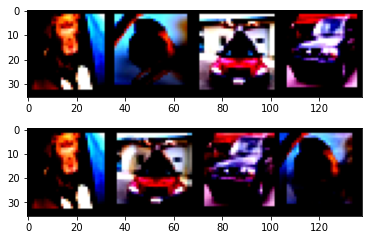

In [64]:
# Test MixUp
config['dataset_name'] = 'CIFAR10'
print("Mixup for", config['dataset_name'])
if config['dataset_name'] == 'mnist':
  batch_img, batch_labels = next(iter(mnist_trainloader_small))
elif config['dataset_name'] == 'CIFAR10':
  batch_img, batch_labels = next(iter(cif10_trainloader_small))
elif config['dataset_name'] == 'CIFAR100':
  batch_img, batch_labels = next(iter(cif100_trainloader_small))

print(batch_img.shape, batch_labels.shape)
batch_img_mixup, y_a, y_b, lam = mixup(batch_img, batch_labels, config['mixup_alpha'])
print("Mixup with lambda", lam)

grid_img  = torchvision.utils.make_grid(batch_img)
grid_img_mixup  = torchvision.utils.make_grid(batch_img_mixup)


plt.figure()
f, axarr = plt.subplots(2,1) 
axarr[0].imshow(grid_img.permute(1, 2, 0))
axarr[1].imshow(grid_img_mixup.permute(1, 2, 0))

#### Train

In [ ]:
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'] )

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = config['weight_decay'], nesterov = True)

# Linear learning rate schedule
scheduler_ft = None
# Cosine learning rate
# scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

# train_model(model, trainloader, testloader, criterion, optimizer, DAmethod, datasetname, num_epochs=25, jsd_loss = False):
with wandb.init(config=config, project='INF8225 - Projet final',  entity = 'inf8225_ym_at', save_code=True, group= 'densenet_mixup'):
  print("Start training", config['dataset_name'], "Model", config['model_name'] )

  if config['dataset_name'] == 'mnist':
    model_ft, hist = train_model(model_ft, mnist_trainloader, mnist_testloader, criterion, optimizer_ft, DAmethod=config['DAmethod'], datasetname=config['dataset_name'], num_epochs=config['epochs'], scheduler=scheduler_ft)

  elif config['dataset_name'] == 'CIFAR10':
    model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, DAmethod=config['DAmethod'], datasetname=config['dataset_name'], num_epochs=config['epochs'], scheduler=scheduler_ft)

  elif config['dataset_name'] == 'CIFAR100':
    model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, DAmethod=config['DAmethod'], datasetname=config['dataset_name'], num_epochs=config['epochs'], scheduler=scheduler_ft)



Start training CIFAR10 Model resnet
Epoch 1/200
----------


26it [00:05,  4.89it/s]


KeyboardInterrupt: ignored

#CutMix

##CutMix Function

In [65]:
def cutmix(inputs, labels, alpha):
  batch_size = inputs.size(0)
  shuffled_batch = torch.randperm(batch_size).to(config['device'])
  second_inputs = inputs[shuffled_batch]
  second_labels = labels[shuffled_batch]
  
  lam = np.random.beta(alpha, alpha)
  
  mixup_inputs = torch.clone(inputs)
  W = mixup_inputs.size(2)
  H = mixup_inputs.size(3)
  for i in range(batch_size):
    height = int(W*np.sqrt(1-lam)) 
    width = int(H*np.sqrt(1-lam))
    rx = np.random.randint(0,W-width)
    ry = np.random.randint(0,H-height)

    mixup_inputs[i,:,ry:ry + height,rx:rx + width] = second_inputs[i,:,ry:ry + height,rx:rx + width]
    #mixup_inputs[i,:,:height,:width] = second_inputs[i,:,:height,:width]

  # labels mixup will be computed in the loss function
  return mixup_inputs, labels, second_labels, lam

In [66]:
def mixup_criterion(criterion, output, original_labels, shuffled_labels, lam):
    return lam * criterion(output, original_labels) + (1 - lam) * criterion(output, shuffled_labels)

## Train

### Resnet

Cifar10 Resnet

In [ ]:
# Initialize the model for this run
config['dataset_name'] = 'CIFAR10'
config['model_name'] =  'resnet'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0001, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_cifar10_Cutmix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'CutMix', datasetname = config['dataset_name'], jsd_loss = False)

Cifar100 Resnet

In [ ]:
# Initialize the model for this run
config['dataset_name'] = 'CIFAR100'
config['model_name'] =  'resnet'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_cifar100_Cutmix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'CutMix', datasetname = config['dataset_name'], jsd_loss = False)

### Densenet

Cifar10 Densenet

In [70]:
# Initialize the model for this run
config['dataset_name'] = 'CIFAR10'
config['model_name'] =  'densenet'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'densenet_cifar10_Cutmix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, num_epochs=config['epochs'], DAmethod = 'CutMix', datasetname = config['dataset_name'], jsd_loss = False, scheduler = scheduler_ft)

Train - loss,▁
Train - loss,4.60659


KeyboardInterrupt: ignored

Cifar100 Densenet

In [ ]:
# Initialize the model for this run
config['dataset_name'] = 'CIFAR100'
config['model_name'] =  'densenet'
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'densenet_cifar100_Cutmix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, num_epochs=config['epochs'], DAmethod = 'CutMix', datasetname = config['dataset_name'], jsd_loss = False, scheduler = scheduler_ft)

# AugMix

## AugMixDataset

In [72]:
def int_parameter(level,maxval):
  return int(level*maxval/10)

def float_parameter(level,maxval):
  return float(level)*maxval/10.

def sample_level(n):
  return np.random.uniform(low=0.1,high=n)

# Operations
def autocontrast(pil_img, _ , IMAGE_SIZE):
  return ImageOps.autocontrast(pil_img)

def equalize(pil_img, _, IMAGE_SIZE):
  return ImageOps.equalize(pil_img)

def posterize(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), 4)
  return ImageOps.posterize(pil_img, 4 - level)

def rotate(pil_img, level, IMAGE_SIZE):
  degrees = int_parameter(sample_level(level), 30)
  if np.random.uniform() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees, resample=Image.BILINEAR)

def solarize(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), 256)
  return ImageOps.solarize(pil_img, 256 - level)

def shear_x(pil_img, level, IMAGE_SIZE):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)

def shear_y(pil_img, level, IMAGE_SIZE):
  level = float_parameter(sample_level(level), 0.3)
  if np.random.uniform() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)

def translate_x(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)

def translate_y(pil_img, level, IMAGE_SIZE):
  level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
  if np.random.random() > 0.5:
    level = -level
  return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)
  
# operation that overlaps with ImageNet-C's test set
def color(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)

def contrast(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)

def brightness(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)

def sharpness(pil_img, level, IMAGE_SIZE):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)

# augmentations list
augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]


In [73]:
def augmix(image, preprocess, dataset_name, mixture_width:int=3, aug_severity = 3, all_ops = True):
  
  if dataset_name == "mnist":
    size = 28
  else:
    size = 32

  aug_list = augmentations
  if all_ops:
    aug_list = augmentations_all
  
  ws = np.float32(np.random.dirichlet([1] * mixture_width))
  m = np.float32(np.random.beta(1,1))

  mix = torch.zeros_like(preprocess(image))

  for i in range(mixture_width):
    image_aug = image.copy()
    depth = np.random.randint(1, 4)
    for _ in range(depth):
      op = np.random.choice(aug_list)
      image_aug = op(image_aug, aug_severity, size)
    mix += ws[i] * preprocess(image_aug)
  
  
  mixed = (1-m) * preprocess(image) + m * mix

  return mixed

class AugMixDataset(torch.utils.data.Dataset):
  def __init__(self,dataset,preprocess,dataset_name,all_ops=True,jsd_loss=False): #,mixture_width = 3
    self.dataset = dataset
    self.preprocess = preprocess
    self.jsd_loss = jsd_loss
    self.dataset_name = dataset_name
    self.all_ops = all_ops
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.jsd_loss:
      im_tuple = (
          self.preprocess(x), 
          augmix(x, self.preprocess, self.dataset_name, self.all_ops),
          augmix(x, self.preprocess, self.dataset_name, self.all_ops),
          )
      return im_tuple,y
    else:
      return augmix(x, self.preprocess, self.dataset_name, self.all_ops), y
  
  def __len__(self):
    return len(self.dataset)

## Preprocessing

In [74]:
# DataSet
# mnist
mnist_train_transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(28,padding=4),
    ])
mnist_preprocess = transforms.Compose([
               Grayscale(num_output_channels=3),
               ToTensor(),
               Normalize([0.1307],[0.3015]),
])
mnist_test_transform = mnist_preprocess

mnist_trainset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform = mnist_train_transform)
mnist_testset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform = mnist_test_transform)

# CIFAR-10
CIFAR10_train_transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(32, padding=4),
    ])
CIFAR10_preprocess = transforms.Compose([
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
])
CIFAR10_test_transform = CIFAR10_preprocess

CIFAR10_trainset = datasets.CIFAR10(root='./data/CIFAR', train=True, download=True, transform = CIFAR10_train_transform)
CIFAR10_testset = datasets.CIFAR10(root='./data/CIFAR', train=False, download=True, transform = CIFAR10_test_transform)

# CIFAR-100
CIFAR100_train_transform = transforms.Compose([
               transforms.RandomHorizontalFlip(),
               transforms.RandomCrop(32, padding=4),
    ])
CIFAR100_preprocess = transforms.Compose([
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
])
CIFAR100_test_transform = CIFAR100_preprocess

CIFAR100_trainset = datasets.CIFAR100(root='./data/CIFAR', train=True, download=True, transform = CIFAR100_train_transform)
CIFAR100_testset = datasets.CIFAR100(root='./data/CIFAR', train=False, download=True, transform = CIFAR100_test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Model training

### Dataloader

In [75]:
jsd_loss = False
mnist_trainset = AugMixDataset(mnist_trainset, mnist_preprocess, 'mnist', jsd_loss = jsd_loss)
CIFAR10_trainset = AugMixDataset(CIFAR10_trainset, CIFAR10_preprocess, 'cifar10', jsd_loss = jsd_loss)
CIFAR100_trainset = AugMixDataset(CIFAR100_trainset, CIFAR100_preprocess, 'cifar100', jsd_loss = jsd_loss)

In [76]:
mnist_trainloader = DataLoader(mnist_trainset, batch_size=config['batch_size'], shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=config['batch_size'])
CIFAR10_trainloader = DataLoader(CIFAR10_trainset, batch_size=config['batch_size'], shuffle=True)
CIFAR10_testloader = DataLoader(CIFAR10_testset, batch_size=config['batch_size'])
CIFAR100_trainloader = DataLoader(CIFAR100_trainset, batch_size=config['batch_size'], shuffle=True)
CIFAR100_testloader = DataLoader(CIFAR100_testset, batch_size=config['batch_size'])

size: torch.Size([3, 28, 28])


<Figure size 432x288 with 0 Axes>

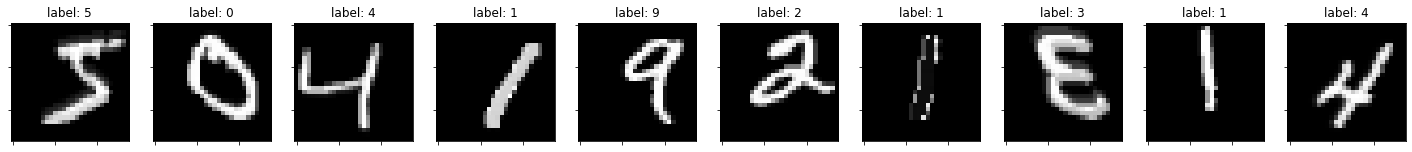

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


size: torch.Size([3, 32, 32])


<Figure size 432x288 with 0 Axes>

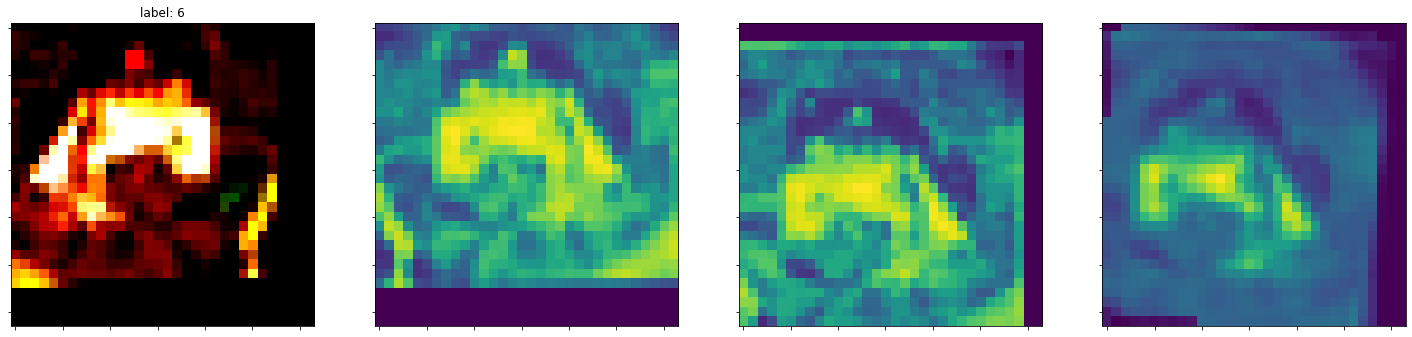

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


size: torch.Size([3, 32, 32])


<Figure size 432x288 with 0 Axes>

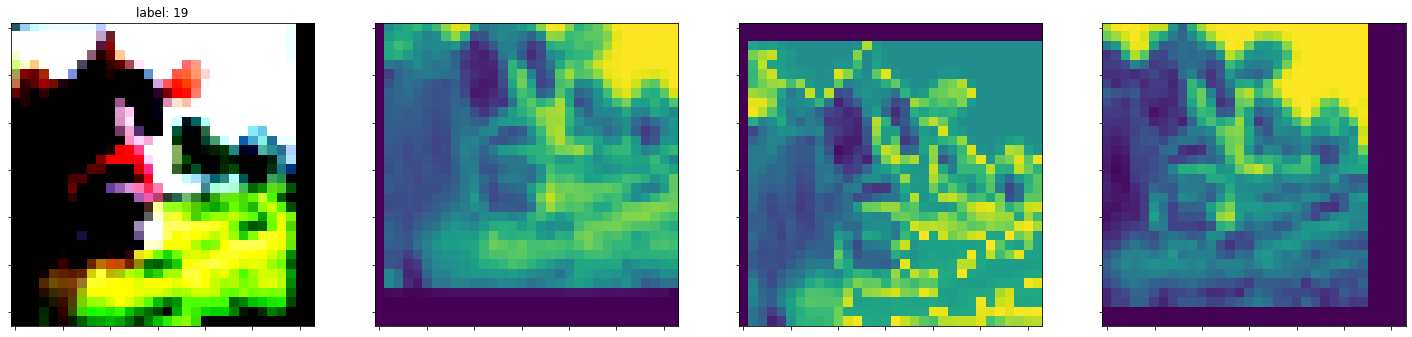

In [77]:
def imshow(dataset):
  if jsd_loss:
    print("size: " + str(dataset[0][0][0].shape))
    if dataset in [mnist_trainset,mnist_testset]:
      plt.figure()
      f,axs = plt.subplots(1,10,figsize=(25,25))
      for i in range(10):
        axs[i].imshow(dataset[i][0][0][0],cmap = 'gray')
        axs[i].set_title("label: " + str(dataset[i][1]))
    else:
      plt.figure()
      f,axs = plt.subplots(1,4,figsize=(25,25))
      for i in range(1):
        axs[i].imshow((np.transpose(dataset[i][0][0],(1,2,0))))
        axs[i+1].imshow((np.transpose(dataset[i][0][0],(1,2,0)))[:,:,0])
        axs[i+2].imshow((np.transpose(dataset[i][0][0],(1,2,0)))[:,:,1])
        axs[i+3].imshow((np.transpose(dataset[i][0][0],(1,2,0)))[:,:,2])
        axs[i].set_title("label: " + str(dataset[i][1]))
    plt.setp([a.get_xticklabels() for a in axs[:]], visible=False) # hide x ticks
    plt.setp([a.get_yticklabels() for a in axs[:]], visible=False) # hide y ticks
    plt.show()
  else:
    print("size: " + str(dataset[0][0].shape))
    if dataset in [mnist_trainset,mnist_testset]:
      plt.figure()
      f,axs = plt.subplots(1,10,figsize=(25,25))
      for i in range(10):
        axs[i].imshow(dataset[i][0][0],cmap = 'gray')
        axs[i].set_title("label: " + str(dataset[i][1]))
    else:
      plt.figure()
      f,axs = plt.subplots(1,4,figsize=(25,25))
      for i in range(1):
        axs[i].imshow((np.transpose(dataset[i][0],(1,2,0))))
        axs[i+1].imshow((np.transpose(dataset[i][0],(1,2,0)))[:,:,0])
        axs[i+2].imshow((np.transpose(dataset[i][0],(1,2,0)))[:,:,1])
        axs[i+3].imshow((np.transpose(dataset[i][0],(1,2,0)))[:,:,2])
        axs[i].set_title("label: " + str(dataset[i][1]))
    plt.setp([a.get_xticklabels() for a in axs[:]], visible=False) # hide x ticks
    plt.setp([a.get_yticklabels() for a in axs[:]], visible=False) # hide y ticks
    plt.show()

imshow(mnist_trainloader.dataset)
imshow(CIFAR10_trainloader.dataset)
imshow(CIFAR100_trainset)

### ResNet18

#### cifar10

In [78]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'cifar10' # mnist cifar10 cifar100


In [79]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_cifar10_AugMix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'AugMix', datasetname = config['dataset_name'], jsd_loss = jsd_loss)

Epoch 1/200
----------


9it [00:02,  3.97it/s]


Train - loss,▁
Train - loss,2.44779


KeyboardInterrupt: ignored

#### cifar100

In [80]:
config['model_name'] = 'resnet'
config['dataset_name'] = 'cifar100'

In [81]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'resnet18_cifar100_AugMix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'AugMix', datasetname = config['dataset_name'], jsd_loss = jsd_loss)

Train - loss,▁
Train - loss,4.78419


KeyboardInterrupt: ignored

### DenseNet121

#### cifar10

In [ ]:
config['model_name'] = 'densenet'
config['dataset_name'] = 'cifar10' # mnist cifar10 cifar100


In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate

model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'densenet121_cifar10_AugMix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR10_trainloader, CIFAR10_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'Baseline', datasetname = config['dataset_name'], jsd_loss = jsd_loss)

Epoch 1/200
----------


391it [02:42,  2.40it/s]


train Loss: 1.8055 Acc: 0.3434
valid Loss: 1.4611 Acc: 0.4785
Saving model...
------------------------------

Epoch 2/200
----------


391it [02:43,  2.38it/s]


train Loss: 1.3234 Acc: 0.5243
valid Loss: 1.0968 Acc: 0.6029
Saving model...
------------------------------

Epoch 3/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.0261 Acc: 0.6339
valid Loss: 0.9314 Acc: 0.6729
Saving model...
------------------------------

Epoch 4/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.8389 Acc: 0.7033
valid Loss: 0.8187 Acc: 0.7189
Saving model...
------------------------------

Epoch 5/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.7085 Acc: 0.7532
valid Loss: 0.6830 Acc: 0.7658
Saving model...
------------------------------

Epoch 6/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.6366 Acc: 0.7808
valid Loss: 0.6783 Acc: 0.7676
Saving model...
------------------------------

Epoch 7/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.5805 Acc: 0.7997
valid Loss: 0.5281 Acc: 0.8212
Saving model...
------------------------------

Epoch 8/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.5519 Acc: 0.8118
valid Loss: 0.5798 Acc: 0.7994
------------------------------

Epoch 9/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.5245 Acc: 0.8209
valid Loss: 0.5172 Acc: 0.8236
Saving model...
------------------------------

Epoch 10/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.5050 Acc: 0.8263
valid Loss: 0.5164 Acc: 0.8239
Saving model...
------------------------------

Epoch 11/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.4891 Acc: 0.8306
valid Loss: 0.5033 Acc: 0.8313
Saving model...
------------------------------

Epoch 12/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.4706 Acc: 0.8384
valid Loss: 0.4563 Acc: 0.8441
Saving model...
------------------------------

Epoch 13/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.4586 Acc: 0.8427
valid Loss: 0.4241 Acc: 0.8527
Saving model...
------------------------------

Epoch 14/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.4506 Acc: 0.8452
valid Loss: 0.4893 Acc: 0.8348
------------------------------

Epoch 15/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.4390 Acc: 0.8500
valid Loss: 0.5174 Acc: 0.8233
------------------------------

Epoch 16/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.4313 Acc: 0.8527
valid Loss: 0.4494 Acc: 0.8494
------------------------------

Epoch 17/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.4215 Acc: 0.8564
valid Loss: 0.4151 Acc: 0.8613
Saving model...
------------------------------

Epoch 18/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.4129 Acc: 0.8590
valid Loss: 0.4192 Acc: 0.8573
------------------------------

Epoch 19/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.4001 Acc: 0.8632
valid Loss: 0.5181 Acc: 0.8337
------------------------------

Epoch 20/200
----------


391it [02:43,  2.38it/s]


train Loss: 0.3899 Acc: 0.8654
valid Loss: 0.4929 Acc: 0.8364
------------------------------

Epoch 21/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3845 Acc: 0.8679
valid Loss: 0.4852 Acc: 0.8414
------------------------------

Epoch 22/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3708 Acc: 0.8739
valid Loss: 0.4201 Acc: 0.8569
------------------------------

Epoch 23/200
----------


391it [02:43,  2.38it/s]


train Loss: 0.3664 Acc: 0.8739
valid Loss: 0.4882 Acc: 0.8326
------------------------------

Epoch 24/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3581 Acc: 0.8773
valid Loss: 0.3666 Acc: 0.8782
Saving model...
------------------------------

Epoch 25/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3470 Acc: 0.8796
valid Loss: 0.3684 Acc: 0.8769
------------------------------

Epoch 26/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3372 Acc: 0.8843
valid Loss: 0.3590 Acc: 0.8749
------------------------------

Epoch 27/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3307 Acc: 0.8861
valid Loss: 0.3979 Acc: 0.8673
------------------------------

Epoch 28/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3217 Acc: 0.8898
valid Loss: 0.3220 Acc: 0.8946
Saving model...
------------------------------

Epoch 29/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3129 Acc: 0.8928
valid Loss: 0.3452 Acc: 0.8829
------------------------------

Epoch 30/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3010 Acc: 0.8967
valid Loss: 0.3271 Acc: 0.8920
------------------------------

Epoch 31/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2883 Acc: 0.9012
valid Loss: 0.3152 Acc: 0.8923
------------------------------

Epoch 32/200
----------


391it [02:43,  2.38it/s]


train Loss: 0.2824 Acc: 0.9032
valid Loss: 0.3545 Acc: 0.8779
------------------------------

Epoch 33/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2710 Acc: 0.9074
valid Loss: 0.2994 Acc: 0.9003
Saving model...
------------------------------

Epoch 34/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2644 Acc: 0.9094
valid Loss: 0.2752 Acc: 0.9086
Saving model...
------------------------------

Epoch 35/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2493 Acc: 0.9140
valid Loss: 0.3332 Acc: 0.8891
------------------------------

Epoch 36/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.2407 Acc: 0.9165
valid Loss: 0.2740 Acc: 0.9076
------------------------------

Epoch 37/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2296 Acc: 0.9212
valid Loss: 0.2901 Acc: 0.9039
------------------------------

Epoch 38/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2212 Acc: 0.9233
valid Loss: 0.2530 Acc: 0.9137
Saving model...
------------------------------

Epoch 39/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2085 Acc: 0.9283
valid Loss: 0.2767 Acc: 0.9065
------------------------------

Epoch 40/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.1948 Acc: 0.9339
valid Loss: 0.2440 Acc: 0.9177
Saving model...
------------------------------

Epoch 41/200
----------


391it [02:43,  2.38it/s]


train Loss: 0.1853 Acc: 0.9355
valid Loss: 0.2457 Acc: 0.9180
Saving model...
------------------------------

Epoch 42/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.1733 Acc: 0.9410
valid Loss: 0.2213 Acc: 0.9259
Saving model...
------------------------------

Epoch 43/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.1617 Acc: 0.9448
valid Loss: 0.2280 Acc: 0.9283
Saving model...
------------------------------

Epoch 44/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.1496 Acc: 0.9484
valid Loss: 0.2092 Acc: 0.9269
------------------------------

Epoch 45/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1349 Acc: 0.9537
valid Loss: 0.2084 Acc: 0.9319
Saving model...
------------------------------

Epoch 46/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.1220 Acc: 0.9593
valid Loss: 0.2028 Acc: 0.9345
Saving model...
------------------------------

Epoch 47/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.1160 Acc: 0.9599
valid Loss: 0.2044 Acc: 0.9359
Saving model...
------------------------------

Epoch 48/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0978 Acc: 0.9682
valid Loss: 0.1822 Acc: 0.9399
Saving model...
------------------------------

Epoch 49/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0870 Acc: 0.9710
valid Loss: 0.1914 Acc: 0.9398
------------------------------

Epoch 50/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0790 Acc: 0.9737
valid Loss: 0.1839 Acc: 0.9409
Saving model...
------------------------------

Epoch 51/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0701 Acc: 0.9765
valid Loss: 0.1765 Acc: 0.9446
Saving model...
------------------------------

Epoch 52/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.0587 Acc: 0.9809
valid Loss: 0.1717 Acc: 0.9465
Saving model...
------------------------------

Epoch 53/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0541 Acc: 0.9825
valid Loss: 0.1713 Acc: 0.9484
Saving model...
------------------------------

Epoch 54/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0463 Acc: 0.9854
valid Loss: 0.1672 Acc: 0.9493
Saving model...
------------------------------

Epoch 55/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0405 Acc: 0.9878
valid Loss: 0.1622 Acc: 0.9515
Saving model...
------------------------------

Epoch 56/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0384 Acc: 0.9887
valid Loss: 0.1583 Acc: 0.9538
Saving model...
------------------------------

Epoch 57/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0334 Acc: 0.9900
valid Loss: 0.1580 Acc: 0.9535
------------------------------

Epoch 58/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0347 Acc: 0.9892
valid Loss: 0.1561 Acc: 0.9538
------------------------------

Epoch 59/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0317 Acc: 0.9904
valid Loss: 0.1572 Acc: 0.9541
Saving model...
------------------------------

Epoch 60/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.0306 Acc: 0.9909
valid Loss: 0.1544 Acc: 0.9551
Saving model...
------------------------------

Epoch 61/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0309 Acc: 0.9911
valid Loss: 0.1549 Acc: 0.9548
------------------------------

Epoch 62/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0307 Acc: 0.9907
valid Loss: 0.1565 Acc: 0.9547
------------------------------

Epoch 63/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0284 Acc: 0.9916
valid Loss: 0.1549 Acc: 0.9554
Saving model...
------------------------------

Epoch 64/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0310 Acc: 0.9906
valid Loss: 0.1567 Acc: 0.9550
------------------------------

Epoch 65/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0310 Acc: 0.9907
valid Loss: 0.1572 Acc: 0.9543
------------------------------

Epoch 66/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0326 Acc: 0.9903
valid Loss: 0.1619 Acc: 0.9522
------------------------------

Epoch 67/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0339 Acc: 0.9901
valid Loss: 0.1678 Acc: 0.9510
------------------------------

Epoch 68/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0377 Acc: 0.9883
valid Loss: 0.1680 Acc: 0.9516
------------------------------

Epoch 69/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0445 Acc: 0.9855
valid Loss: 0.1661 Acc: 0.9506
------------------------------

Epoch 70/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0497 Acc: 0.9841
valid Loss: 0.1818 Acc: 0.9475
------------------------------

Epoch 71/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0594 Acc: 0.9811
valid Loss: 0.1782 Acc: 0.9470
------------------------------

Epoch 72/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0736 Acc: 0.9761
valid Loss: 0.1971 Acc: 0.9399
------------------------------

Epoch 73/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0909 Acc: 0.9696
valid Loss: 0.2090 Acc: 0.9330
------------------------------

Epoch 74/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.1095 Acc: 0.9635
valid Loss: 0.2261 Acc: 0.9327
------------------------------

Epoch 75/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.1262 Acc: 0.9566
valid Loss: 0.2339 Acc: 0.9266
------------------------------

Epoch 76/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.1459 Acc: 0.9502
valid Loss: 0.2760 Acc: 0.9139
------------------------------

Epoch 77/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.1647 Acc: 0.9425
valid Loss: 0.2477 Acc: 0.9239
------------------------------

Epoch 78/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.1745 Acc: 0.9400
valid Loss: 0.3081 Acc: 0.9066
------------------------------

Epoch 79/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.1882 Acc: 0.9352
valid Loss: 0.2669 Acc: 0.9102
------------------------------

Epoch 80/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2056 Acc: 0.9287
valid Loss: 0.2551 Acc: 0.9175
------------------------------

Epoch 81/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2110 Acc: 0.9267
valid Loss: 0.2809 Acc: 0.9082
------------------------------

Epoch 82/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2141 Acc: 0.9256
valid Loss: 0.3034 Acc: 0.8999
------------------------------

Epoch 83/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2241 Acc: 0.9224
valid Loss: 0.3036 Acc: 0.9005
------------------------------

Epoch 84/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2330 Acc: 0.9194
valid Loss: 0.2986 Acc: 0.9002
------------------------------

Epoch 85/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2379 Acc: 0.9183
valid Loss: 0.3268 Acc: 0.8926
------------------------------

Epoch 86/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2441 Acc: 0.9151
valid Loss: 0.3025 Acc: 0.9032
------------------------------

Epoch 87/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2417 Acc: 0.9179
valid Loss: 0.3134 Acc: 0.8947
------------------------------

Epoch 88/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2558 Acc: 0.9129
valid Loss: 0.2792 Acc: 0.9075
------------------------------

Epoch 89/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2555 Acc: 0.9133
valid Loss: 0.3477 Acc: 0.8866
------------------------------

Epoch 90/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2673 Acc: 0.9072
valid Loss: 0.3343 Acc: 0.8849
------------------------------

Epoch 91/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2682 Acc: 0.9068
valid Loss: 0.2822 Acc: 0.9023
------------------------------

Epoch 92/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2787 Acc: 0.9038
valid Loss: 0.3667 Acc: 0.8802
------------------------------

Epoch 93/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2774 Acc: 0.9041
valid Loss: 0.3830 Acc: 0.8756
------------------------------

Epoch 94/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.2857 Acc: 0.9017
valid Loss: 0.3894 Acc: 0.8758
------------------------------

Epoch 95/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2900 Acc: 0.9002
valid Loss: 0.3400 Acc: 0.8860
------------------------------

Epoch 96/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2907 Acc: 0.9001
valid Loss: 0.3905 Acc: 0.8751
------------------------------

Epoch 97/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2999 Acc: 0.8976
valid Loss: 0.3451 Acc: 0.8848
------------------------------

Epoch 98/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.3065 Acc: 0.8951
valid Loss: 0.3239 Acc: 0.8899
------------------------------

Epoch 99/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3054 Acc: 0.8951
valid Loss: 0.3697 Acc: 0.8789
------------------------------

Epoch 100/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3110 Acc: 0.8926
valid Loss: 0.3690 Acc: 0.8733
------------------------------

Epoch 101/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3189 Acc: 0.8906
valid Loss: 0.3828 Acc: 0.8718
------------------------------

Epoch 102/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.3189 Acc: 0.8905
valid Loss: 0.4474 Acc: 0.8454
------------------------------

Epoch 103/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.3208 Acc: 0.8907
valid Loss: 0.5014 Acc: 0.8442
------------------------------

Epoch 104/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.3274 Acc: 0.8881
valid Loss: 0.3950 Acc: 0.8643
------------------------------

Epoch 105/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.3301 Acc: 0.8862
valid Loss: 0.3901 Acc: 0.8735
------------------------------

Epoch 106/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.3416 Acc: 0.8836
valid Loss: 0.5864 Acc: 0.8221
------------------------------

Epoch 107/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.3353 Acc: 0.8845
valid Loss: 0.3515 Acc: 0.8783
------------------------------

Epoch 108/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3405 Acc: 0.8813
valid Loss: 0.4471 Acc: 0.8493
------------------------------

Epoch 109/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3466 Acc: 0.8819
valid Loss: 0.5077 Acc: 0.8383
------------------------------

Epoch 110/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3455 Acc: 0.8809
valid Loss: 0.5420 Acc: 0.8274
------------------------------

Epoch 111/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3452 Acc: 0.8836
valid Loss: 0.3575 Acc: 0.8806
------------------------------

Epoch 112/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3499 Acc: 0.8794
valid Loss: 0.4011 Acc: 0.8652
------------------------------

Epoch 113/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3530 Acc: 0.8791
valid Loss: 0.4404 Acc: 0.8550
------------------------------

Epoch 114/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3517 Acc: 0.8790
valid Loss: 0.4210 Acc: 0.8616
------------------------------

Epoch 115/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3537 Acc: 0.8777
valid Loss: 0.3728 Acc: 0.8670
------------------------------

Epoch 116/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3584 Acc: 0.8771
valid Loss: 0.4858 Acc: 0.8415
------------------------------

Epoch 117/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3572 Acc: 0.8768
valid Loss: 0.3971 Acc: 0.8632
------------------------------

Epoch 118/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3570 Acc: 0.8782
valid Loss: 0.3850 Acc: 0.8709
------------------------------

Epoch 119/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3573 Acc: 0.8786
valid Loss: 0.3673 Acc: 0.8759
------------------------------

Epoch 120/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3595 Acc: 0.8765
valid Loss: 0.4056 Acc: 0.8644
------------------------------

Epoch 121/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3605 Acc: 0.8764
valid Loss: 0.4459 Acc: 0.8548
------------------------------

Epoch 122/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3570 Acc: 0.8772
valid Loss: 0.4223 Acc: 0.8560
------------------------------

Epoch 123/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.3588 Acc: 0.8768
valid Loss: 0.3915 Acc: 0.8699
------------------------------

Epoch 124/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3625 Acc: 0.8750
valid Loss: 0.4217 Acc: 0.8607
------------------------------

Epoch 125/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3559 Acc: 0.8800
valid Loss: 0.4422 Acc: 0.8530
------------------------------

Epoch 126/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3660 Acc: 0.8762
valid Loss: 0.3553 Acc: 0.8781
------------------------------

Epoch 127/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3523 Acc: 0.8790
valid Loss: 0.4437 Acc: 0.8513
------------------------------

Epoch 128/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3543 Acc: 0.8802
valid Loss: 0.3644 Acc: 0.8757
------------------------------

Epoch 129/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.3561 Acc: 0.8784
valid Loss: 0.4293 Acc: 0.8524
------------------------------

Epoch 130/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3463 Acc: 0.8814
valid Loss: 0.3982 Acc: 0.8707
------------------------------

Epoch 131/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3435 Acc: 0.8822
valid Loss: 0.3973 Acc: 0.8654
------------------------------

Epoch 132/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.3421 Acc: 0.8826
valid Loss: 0.3861 Acc: 0.8669
------------------------------

Epoch 133/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3409 Acc: 0.8838
valid Loss: 0.3768 Acc: 0.8640
------------------------------

Epoch 134/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3354 Acc: 0.8841
valid Loss: 0.4042 Acc: 0.8640
------------------------------

Epoch 135/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3317 Acc: 0.8868
valid Loss: 0.4943 Acc: 0.8385
------------------------------

Epoch 136/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3320 Acc: 0.8851
valid Loss: 0.3866 Acc: 0.8705
------------------------------

Epoch 137/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3254 Acc: 0.8871
valid Loss: 0.3413 Acc: 0.8841
------------------------------

Epoch 138/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3229 Acc: 0.8906
valid Loss: 0.3328 Acc: 0.8863
------------------------------

Epoch 139/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.3164 Acc: 0.8921
valid Loss: 0.3726 Acc: 0.8783
------------------------------

Epoch 140/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3101 Acc: 0.8938
valid Loss: 0.6173 Acc: 0.8112
------------------------------

Epoch 141/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3121 Acc: 0.8932
valid Loss: 0.3600 Acc: 0.8779
------------------------------

Epoch 142/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.3018 Acc: 0.8967
valid Loss: 0.4244 Acc: 0.8629
------------------------------

Epoch 143/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.2971 Acc: 0.8982
valid Loss: 0.3295 Acc: 0.8911
------------------------------

Epoch 144/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2920 Acc: 0.8995
valid Loss: 0.3598 Acc: 0.8810
------------------------------

Epoch 145/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.2870 Acc: 0.9008
valid Loss: 0.3702 Acc: 0.8755
------------------------------

Epoch 146/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2750 Acc: 0.9068
valid Loss: 0.4345 Acc: 0.8613
------------------------------

Epoch 147/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2752 Acc: 0.9055
valid Loss: 0.3295 Acc: 0.8875
------------------------------

Epoch 148/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2674 Acc: 0.9084
valid Loss: 0.3258 Acc: 0.8903
------------------------------

Epoch 149/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2556 Acc: 0.9123
valid Loss: 0.3438 Acc: 0.8830
------------------------------

Epoch 150/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2544 Acc: 0.9131
valid Loss: 0.3366 Acc: 0.8871
------------------------------

Epoch 151/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2445 Acc: 0.9158
valid Loss: 0.2806 Acc: 0.9055
------------------------------

Epoch 152/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2325 Acc: 0.9203
valid Loss: 0.3058 Acc: 0.9003
------------------------------

Epoch 153/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.2278 Acc: 0.9212
valid Loss: 0.2847 Acc: 0.9061
------------------------------

Epoch 154/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.2181 Acc: 0.9246
valid Loss: 0.3610 Acc: 0.8865
------------------------------

Epoch 155/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.2063 Acc: 0.9285
valid Loss: 0.2619 Acc: 0.9110
------------------------------

Epoch 156/200
----------


391it [02:58,  2.19it/s]


train Loss: 0.1986 Acc: 0.9314
valid Loss: 0.2414 Acc: 0.9192
------------------------------

Epoch 157/200
----------


391it [02:58,  2.19it/s]


train Loss: 0.1904 Acc: 0.9353
valid Loss: 0.2362 Acc: 0.9235
------------------------------

Epoch 158/200
----------


391it [02:58,  2.19it/s]


train Loss: 0.1772 Acc: 0.9383
valid Loss: 0.2557 Acc: 0.9147
------------------------------

Epoch 159/200
----------


391it [02:58,  2.20it/s]


train Loss: 0.1755 Acc: 0.9405
valid Loss: 0.2587 Acc: 0.9157
------------------------------

Epoch 160/200
----------


391it [02:58,  2.20it/s]


train Loss: 0.1581 Acc: 0.9473
valid Loss: 0.2369 Acc: 0.9211
------------------------------

Epoch 161/200
----------


391it [02:46,  2.34it/s]


train Loss: 0.1543 Acc: 0.9465
valid Loss: 0.2215 Acc: 0.9283
------------------------------

Epoch 162/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.1405 Acc: 0.9522
valid Loss: 0.2085 Acc: 0.9311
------------------------------

Epoch 163/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1312 Acc: 0.9555
valid Loss: 0.2001 Acc: 0.9343
------------------------------

Epoch 164/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1228 Acc: 0.9591
valid Loss: 0.2105 Acc: 0.9328
------------------------------

Epoch 165/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1080 Acc: 0.9636
valid Loss: 0.2051 Acc: 0.9360
------------------------------

Epoch 166/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0986 Acc: 0.9671
valid Loss: 0.1923 Acc: 0.9363
------------------------------

Epoch 167/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0881 Acc: 0.9706
valid Loss: 0.1788 Acc: 0.9440
------------------------------

Epoch 168/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.0807 Acc: 0.9734
valid Loss: 0.1645 Acc: 0.9455
------------------------------

Epoch 169/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0696 Acc: 0.9772
valid Loss: 0.1788 Acc: 0.9416
------------------------------

Epoch 170/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0618 Acc: 0.9798
valid Loss: 0.1514 Acc: 0.9519
------------------------------

Epoch 171/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0564 Acc: 0.9816
valid Loss: 0.1476 Acc: 0.9541
------------------------------

Epoch 172/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0474 Acc: 0.9844
valid Loss: 0.1572 Acc: 0.9498
------------------------------

Epoch 173/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0409 Acc: 0.9871
valid Loss: 0.1519 Acc: 0.9521
------------------------------

Epoch 174/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.0367 Acc: 0.9884
valid Loss: 0.1468 Acc: 0.9549
------------------------------

Epoch 175/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0295 Acc: 0.9916
valid Loss: 0.1440 Acc: 0.9569
Saving model...
------------------------------

Epoch 176/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0313 Acc: 0.9910
valid Loss: 0.1418 Acc: 0.9576
Saving model...
------------------------------

Epoch 177/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0294 Acc: 0.9907
valid Loss: 0.1397 Acc: 0.9578
Saving model...
------------------------------

Epoch 178/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0274 Acc: 0.9919
valid Loss: 0.1381 Acc: 0.9585
Saving model...
------------------------------

Epoch 179/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0273 Acc: 0.9916
valid Loss: 0.1383 Acc: 0.9589
Saving model...
------------------------------

Epoch 180/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0287 Acc: 0.9913
valid Loss: 0.1375 Acc: 0.9586
------------------------------

Epoch 181/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0270 Acc: 0.9919
valid Loss: 0.1385 Acc: 0.9580
------------------------------

Epoch 182/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0256 Acc: 0.9928
valid Loss: 0.1381 Acc: 0.9580
------------------------------

Epoch 183/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0258 Acc: 0.9929
valid Loss: 0.1391 Acc: 0.9576
------------------------------

Epoch 184/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0269 Acc: 0.9922
valid Loss: 0.1383 Acc: 0.9577
------------------------------

Epoch 185/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0268 Acc: 0.9922
valid Loss: 0.1396 Acc: 0.9584
------------------------------

Epoch 186/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0274 Acc: 0.9918
valid Loss: 0.1424 Acc: 0.9580
------------------------------

Epoch 187/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0281 Acc: 0.9917
valid Loss: 0.1478 Acc: 0.9559
------------------------------

Epoch 188/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0297 Acc: 0.9912
valid Loss: 0.1489 Acc: 0.9560
------------------------------

Epoch 189/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.0330 Acc: 0.9897
valid Loss: 0.1437 Acc: 0.9569
------------------------------

Epoch 190/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0392 Acc: 0.9877
valid Loss: 0.1552 Acc: 0.9522
------------------------------

Epoch 191/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0458 Acc: 0.9853
valid Loss: 0.1673 Acc: 0.9494
------------------------------

Epoch 192/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0582 Acc: 0.9816
valid Loss: 0.1898 Acc: 0.9424
------------------------------

Epoch 193/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.0725 Acc: 0.9756
valid Loss: 0.1871 Acc: 0.9440
------------------------------

Epoch 194/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.0883 Acc: 0.9706
valid Loss: 0.2190 Acc: 0.9335
------------------------------

Epoch 195/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.1050 Acc: 0.9651
valid Loss: 0.2155 Acc: 0.9322
------------------------------

Epoch 196/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.1293 Acc: 0.9561
valid Loss: 0.2130 Acc: 0.9330
------------------------------

Epoch 197/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.1404 Acc: 0.9517
valid Loss: 0.2632 Acc: 0.9165
------------------------------

Epoch 198/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.1532 Acc: 0.9480
valid Loss: 0.2714 Acc: 0.9153
------------------------------

Epoch 199/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.1720 Acc: 0.9417
valid Loss: 0.2567 Acc: 0.9146
------------------------------

Epoch 200/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.1750 Acc: 0.9407
valid Loss: 0.2727 Acc: 0.9142
------------------------------

Best model saved.
Training complete in 578m 19s
Best val Acc: 0.958900


Train - acc,▁▅▆▆▆▆▇▇▇██████▇▇▇▇▇▆▆▆▆▆▆▆▆▇▇▇▇███████▇
Train - loss,█▄▄▄▃▃▃▃▂▂▁▁▁▁▁▂▂▃▂▃▃▃▃▄▃▃▄▃▃▂▂▂▁▁▁▁▁▁▂▁
Valid - acc,▁▄▆▆▆▆▆▇▇██████▇▇▇▆▇▆▆▆▆▆▆▆▇▆▇▇▇▇██████▇
Valid - loss,█▅▃▃▃▃▃▂▂▁▁▁▁▁▁▂▂▂▃▂▃▃▃▃▃▃▃▂▃▂▃▂▂▁▁▁▁▁▂▂
Train - acc,0.9407
Train - loss,0.06109
Valid - acc,0.9142
Valid - loss,0.27268


#### cifar100

In [ ]:
config['model_name'] = 'densenet'
config['dataset_name'] = 'cifar100' # mnist cifar10 cifar100


In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'])

# Print the model we just instantiated
# summary(model_ft)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'densenet121_cifar100_AugMix',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, scheduler_ft, num_epochs=config['epochs'], DAmethod = 'Baseline', datasetname = config['dataset_name'], jsd_loss = jsd_loss)

Epoch 1/200
----------


391it [02:43,  2.39it/s]


train Loss: 3.9552 Acc: 0.0942
valid Loss: 3.4223 Acc: 0.1742
Saving model...
------------------------------

Epoch 2/200
----------


391it [02:44,  2.38it/s]


train Loss: 3.1953 Acc: 0.2127
valid Loss: 2.8311 Acc: 0.2759
Saving model...
------------------------------

Epoch 3/200
----------


391it [02:44,  2.38it/s]


train Loss: 2.5711 Acc: 0.3304
valid Loss: 2.7228 Acc: 0.3108
Saving model...
------------------------------

Epoch 4/200
----------


391it [02:44,  2.37it/s]


train Loss: 2.2370 Acc: 0.4029
valid Loss: 2.0857 Acc: 0.4332
Saving model...
------------------------------

Epoch 5/200
----------


391it [02:44,  2.37it/s]


train Loss: 2.0204 Acc: 0.4533
valid Loss: 1.9384 Acc: 0.4754
Saving model...
------------------------------

Epoch 6/200
----------


391it [02:45,  2.37it/s]


train Loss: 1.8819 Acc: 0.4819
valid Loss: 1.9183 Acc: 0.4784
Saving model...
------------------------------

Epoch 7/200
----------


391it [02:45,  2.37it/s]


train Loss: 1.7449 Acc: 0.5208
valid Loss: 1.8188 Acc: 0.5056
Saving model...
------------------------------

Epoch 8/200
----------


391it [02:44,  2.37it/s]


train Loss: 1.6591 Acc: 0.5385
valid Loss: 1.7332 Acc: 0.5303
Saving model...
------------------------------

Epoch 9/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.5871 Acc: 0.5568
valid Loss: 1.5930 Acc: 0.5532
Saving model...
------------------------------

Epoch 10/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.5294 Acc: 0.5710
valid Loss: 1.6061 Acc: 0.5587
Saving model...
------------------------------

Epoch 11/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.4796 Acc: 0.5828
valid Loss: 1.8039 Acc: 0.5189
------------------------------

Epoch 12/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.4375 Acc: 0.5925
valid Loss: 1.7034 Acc: 0.5478
------------------------------

Epoch 13/200
----------


391it [02:43,  2.40it/s]


train Loss: 1.3928 Acc: 0.6067
valid Loss: 1.5852 Acc: 0.5562
------------------------------

Epoch 14/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.3731 Acc: 0.6097
valid Loss: 1.6965 Acc: 0.5398
------------------------------

Epoch 15/200
----------


391it [02:43,  2.40it/s]


train Loss: 1.3405 Acc: 0.6218
valid Loss: 1.5310 Acc: 0.5730
Saving model...
------------------------------

Epoch 16/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.3170 Acc: 0.6230
valid Loss: 1.5170 Acc: 0.5866
Saving model...
------------------------------

Epoch 17/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.2786 Acc: 0.6335
valid Loss: 1.4895 Acc: 0.5843
------------------------------

Epoch 18/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.2684 Acc: 0.6353
valid Loss: 1.4559 Acc: 0.6032
Saving model...
------------------------------

Epoch 19/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.2254 Acc: 0.6468
valid Loss: 1.4790 Acc: 0.5899
------------------------------

Epoch 20/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.2023 Acc: 0.6546
valid Loss: 1.5850 Acc: 0.5788
------------------------------

Epoch 21/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.1785 Acc: 0.6609
valid Loss: 1.3521 Acc: 0.6252
Saving model...
------------------------------

Epoch 22/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.1457 Acc: 0.6699
valid Loss: 1.3479 Acc: 0.6262
Saving model...
------------------------------

Epoch 23/200
----------


391it [02:44,  2.38it/s]


train Loss: 1.1258 Acc: 0.6761
valid Loss: 1.3116 Acc: 0.6336
Saving model...
------------------------------

Epoch 24/200
----------


391it [02:44,  2.38it/s]


train Loss: 1.0991 Acc: 0.6816
valid Loss: 1.3694 Acc: 0.6257
------------------------------

Epoch 25/200
----------


391it [02:43,  2.39it/s]


train Loss: 1.0713 Acc: 0.6874
valid Loss: 1.2857 Acc: 0.6386
Saving model...
------------------------------

Epoch 26/200
----------


391it [02:44,  2.38it/s]


train Loss: 1.0501 Acc: 0.6953
valid Loss: 1.2816 Acc: 0.6433
Saving model...
------------------------------

Epoch 27/200
----------


391it [02:44,  2.38it/s]


train Loss: 1.0202 Acc: 0.7024
valid Loss: 1.2882 Acc: 0.6431
------------------------------

Epoch 28/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.9980 Acc: 0.7073
valid Loss: 1.2912 Acc: 0.6430
------------------------------

Epoch 29/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.9605 Acc: 0.7196
valid Loss: 1.3120 Acc: 0.6473
Saving model...
------------------------------

Epoch 30/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.9275 Acc: 0.7281
valid Loss: 1.1926 Acc: 0.6672
Saving model...
------------------------------

Epoch 31/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.9045 Acc: 0.7348
valid Loss: 1.2814 Acc: 0.6523
------------------------------

Epoch 32/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.8777 Acc: 0.7405
valid Loss: 1.1566 Acc: 0.6814
Saving model...
------------------------------

Epoch 33/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.8443 Acc: 0.7509
valid Loss: 1.1854 Acc: 0.6757
------------------------------

Epoch 34/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.8101 Acc: 0.7596
valid Loss: 1.1579 Acc: 0.6826
Saving model...
------------------------------

Epoch 35/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.7727 Acc: 0.7702
valid Loss: 1.1064 Acc: 0.6912
Saving model...
------------------------------

Epoch 36/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.7503 Acc: 0.7759
valid Loss: 1.1043 Acc: 0.6920
Saving model...
------------------------------

Epoch 37/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.7007 Acc: 0.7912
valid Loss: 1.1218 Acc: 0.6935
Saving model...
------------------------------

Epoch 38/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.6638 Acc: 0.7985
valid Loss: 1.1148 Acc: 0.6972
Saving model...
------------------------------

Epoch 39/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.6369 Acc: 0.8077
valid Loss: 1.0434 Acc: 0.7100
Saving model...
------------------------------

Epoch 40/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.5913 Acc: 0.8240
valid Loss: 1.0433 Acc: 0.7113
Saving model...
------------------------------

Epoch 41/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.5561 Acc: 0.8344
valid Loss: 0.9886 Acc: 0.7286
Saving model...
------------------------------

Epoch 42/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.5119 Acc: 0.8450
valid Loss: 1.0297 Acc: 0.7250
------------------------------

Epoch 43/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.4765 Acc: 0.8583
valid Loss: 0.9461 Acc: 0.7394
Saving model...
------------------------------

Epoch 44/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.4273 Acc: 0.8716
valid Loss: 0.9741 Acc: 0.7344
------------------------------

Epoch 45/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.3935 Acc: 0.8818
valid Loss: 0.9416 Acc: 0.7416
Saving model...
------------------------------

Epoch 46/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.3454 Acc: 0.8971
valid Loss: 0.9241 Acc: 0.7487
Saving model...
------------------------------

Epoch 47/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.3064 Acc: 0.9099
valid Loss: 0.8965 Acc: 0.7559
Saving model...
------------------------------

Epoch 48/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.2642 Acc: 0.9236
valid Loss: 0.9254 Acc: 0.7573
Saving model...
------------------------------

Epoch 49/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.2342 Acc: 0.9327
valid Loss: 0.8771 Acc: 0.7651
Saving model...
------------------------------

Epoch 50/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.1987 Acc: 0.9455
valid Loss: 0.8403 Acc: 0.7750
Saving model...
------------------------------

Epoch 51/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.1771 Acc: 0.9521
valid Loss: 0.8600 Acc: 0.7751
Saving model...
------------------------------

Epoch 52/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.1531 Acc: 0.9595
valid Loss: 0.8279 Acc: 0.7778
Saving model...
------------------------------

Epoch 53/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1398 Acc: 0.9640
valid Loss: 0.8301 Acc: 0.7810
Saving model...
------------------------------

Epoch 54/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.1176 Acc: 0.9711
valid Loss: 0.8146 Acc: 0.7830
Saving model...
------------------------------

Epoch 55/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1068 Acc: 0.9738
valid Loss: 0.8155 Acc: 0.7838
Saving model...
------------------------------

Epoch 56/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1013 Acc: 0.9742
valid Loss: 0.8120 Acc: 0.7872
Saving model...
------------------------------

Epoch 57/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0929 Acc: 0.9782
valid Loss: 0.8072 Acc: 0.7870
------------------------------

Epoch 58/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0892 Acc: 0.9788
valid Loss: 0.8037 Acc: 0.7887
Saving model...
------------------------------

Epoch 59/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0844 Acc: 0.9808
valid Loss: 0.8031 Acc: 0.7895
Saving model...
------------------------------

Epoch 60/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0822 Acc: 0.9814
valid Loss: 0.8031 Acc: 0.7882
------------------------------

Epoch 61/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0832 Acc: 0.9801
valid Loss: 0.8001 Acc: 0.7884
------------------------------

Epoch 62/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0856 Acc: 0.9803
valid Loss: 0.8032 Acc: 0.7874
------------------------------

Epoch 63/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0846 Acc: 0.9804
valid Loss: 0.8045 Acc: 0.7885
------------------------------

Epoch 64/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.0849 Acc: 0.9802
valid Loss: 0.8010 Acc: 0.7889
------------------------------

Epoch 65/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.0846 Acc: 0.9806
valid Loss: 0.8042 Acc: 0.7914
Saving model...
------------------------------

Epoch 66/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.0895 Acc: 0.9775
valid Loss: 0.8091 Acc: 0.7868
------------------------------

Epoch 67/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.0898 Acc: 0.9785
valid Loss: 0.8131 Acc: 0.7856
------------------------------

Epoch 68/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.0946 Acc: 0.9771
valid Loss: 0.8373 Acc: 0.7803
------------------------------

Epoch 69/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.1024 Acc: 0.9743
valid Loss: 0.8497 Acc: 0.7797
------------------------------

Epoch 70/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1211 Acc: 0.9690
valid Loss: 0.8813 Acc: 0.7742
------------------------------

Epoch 71/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.1484 Acc: 0.9607
valid Loss: 0.9456 Acc: 0.7614
------------------------------

Epoch 72/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.1779 Acc: 0.9512
valid Loss: 0.9573 Acc: 0.7572
------------------------------

Epoch 73/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.2246 Acc: 0.9359
valid Loss: 0.9753 Acc: 0.7483
------------------------------

Epoch 74/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.2836 Acc: 0.9187
valid Loss: 1.0237 Acc: 0.7349
------------------------------

Epoch 75/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.3480 Acc: 0.8951
valid Loss: 1.0508 Acc: 0.7286
------------------------------

Epoch 76/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.4165 Acc: 0.8746
valid Loss: 1.0290 Acc: 0.7261
------------------------------

Epoch 77/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.4662 Acc: 0.8611
valid Loss: 1.1470 Acc: 0.7024
------------------------------

Epoch 78/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.5245 Acc: 0.8405
valid Loss: 1.0960 Acc: 0.7121
------------------------------

Epoch 79/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.5551 Acc: 0.8316
valid Loss: 1.1241 Acc: 0.7019
------------------------------

Epoch 80/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.5925 Acc: 0.8206
valid Loss: 1.1594 Acc: 0.6883
------------------------------

Epoch 81/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.6184 Acc: 0.8133
valid Loss: 1.2166 Acc: 0.6851
------------------------------

Epoch 82/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.6420 Acc: 0.8060
valid Loss: 1.1716 Acc: 0.6930
------------------------------

Epoch 83/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.6652 Acc: 0.8005
valid Loss: 1.2176 Acc: 0.6755
------------------------------

Epoch 84/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.6709 Acc: 0.7989
valid Loss: 1.1531 Acc: 0.6904
------------------------------

Epoch 85/200
----------


391it [02:42,  2.40it/s]


train Loss: 0.7044 Acc: 0.7869
valid Loss: 1.1482 Acc: 0.6850
------------------------------

Epoch 86/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.7172 Acc: 0.7847
valid Loss: 1.1126 Acc: 0.6918
------------------------------

Epoch 87/200
----------


391it [02:43,  2.40it/s]


train Loss: 0.7291 Acc: 0.7821
valid Loss: 1.1676 Acc: 0.6822
------------------------------

Epoch 88/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.7519 Acc: 0.7743
valid Loss: 1.3205 Acc: 0.6539
------------------------------

Epoch 89/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.7741 Acc: 0.7683
valid Loss: 1.2940 Acc: 0.6570
------------------------------

Epoch 90/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.7842 Acc: 0.7668
valid Loss: 1.3656 Acc: 0.6402
------------------------------

Epoch 91/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.8007 Acc: 0.7628
valid Loss: 1.1781 Acc: 0.6831
------------------------------

Epoch 92/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.8223 Acc: 0.7540
valid Loss: 1.2354 Acc: 0.6681
------------------------------

Epoch 93/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.8434 Acc: 0.7512
valid Loss: 1.3603 Acc: 0.6368
------------------------------

Epoch 94/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.8615 Acc: 0.7422
valid Loss: 1.2596 Acc: 0.6564
------------------------------

Epoch 95/200
----------


391it [02:43,  2.39it/s]


train Loss: 0.8687 Acc: 0.7416
valid Loss: 1.3076 Acc: 0.6587
------------------------------

Epoch 96/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.8886 Acc: 0.7367
valid Loss: 1.2936 Acc: 0.6503
------------------------------

Epoch 97/200
----------


391it [02:44,  2.37it/s]


train Loss: 0.9096 Acc: 0.7299
valid Loss: 1.2869 Acc: 0.6513
------------------------------

Epoch 98/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.9215 Acc: 0.7274
valid Loss: 1.3262 Acc: 0.6531
------------------------------

Epoch 99/200
----------


391it [02:46,  2.36it/s]


train Loss: 0.9269 Acc: 0.7277
valid Loss: 1.2985 Acc: 0.6464
------------------------------

Epoch 100/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.9462 Acc: 0.7226
valid Loss: 1.4215 Acc: 0.6204
------------------------------

Epoch 101/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.9599 Acc: 0.7176
valid Loss: 1.3483 Acc: 0.6369
------------------------------

Epoch 102/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.9838 Acc: 0.7106
valid Loss: 1.5556 Acc: 0.5936
------------------------------

Epoch 103/200
----------


391it [02:44,  2.38it/s]


train Loss: 0.9921 Acc: 0.7117
valid Loss: 1.4928 Acc: 0.6097
------------------------------

Epoch 104/200
----------


391it [02:45,  2.37it/s]


train Loss: 0.9968 Acc: 0.7108
valid Loss: 1.2823 Acc: 0.6463
------------------------------

Epoch 105/200
----------


391it [02:45,  2.37it/s]


train Loss: 1.0253 Acc: 0.7015
valid Loss: 1.3164 Acc: 0.6340
------------------------------

Epoch 106/200
----------


391it [02:45,  2.37it/s]


train Loss: 1.0249 Acc: 0.7005
valid Loss: 1.4418 Acc: 0.6206
------------------------------

Epoch 107/200
----------


391it [02:45,  2.36it/s]


train Loss: 1.0396 Acc: 0.6965
valid Loss: 1.4795 Acc: 0.6072
------------------------------

Epoch 108/200
----------


391it [02:45,  2.36it/s]


train Loss: 1.0498 Acc: 0.6966
valid Loss: 1.3775 Acc: 0.6226
------------------------------

Epoch 109/200
----------


391it [02:45,  2.36it/s]


train Loss: 1.0550 Acc: 0.6926
valid Loss: 1.3993 Acc: 0.6243
------------------------------

Epoch 110/200
----------


391it [02:46,  2.35it/s]


train Loss: 1.0725 Acc: 0.6889
valid Loss: 1.5392 Acc: 0.6080
------------------------------

Epoch 111/200
----------


391it [02:46,  2.35it/s]


train Loss: 1.0755 Acc: 0.6875
valid Loss: 1.4436 Acc: 0.6162
------------------------------

Epoch 112/200
----------


391it [02:45,  2.36it/s]


train Loss: 1.0892 Acc: 0.6837
valid Loss: 1.5374 Acc: 0.5870
------------------------------

Epoch 113/200
----------


391it [02:45,  2.36it/s]


train Loss: 1.0868 Acc: 0.6875
valid Loss: 1.4779 Acc: 0.6112
------------------------------

Epoch 114/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.0963 Acc: 0.6837
valid Loss: 1.3225 Acc: 0.6348
------------------------------

Epoch 115/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.0974 Acc: 0.6835
valid Loss: 1.5375 Acc: 0.5944
------------------------------

Epoch 116/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.1056 Acc: 0.6780
valid Loss: 1.3281 Acc: 0.6340
------------------------------

Epoch 117/200
----------


391it [02:47,  2.34it/s]


train Loss: 1.1030 Acc: 0.6815
valid Loss: 1.3869 Acc: 0.6260
------------------------------

Epoch 118/200
----------


391it [02:47,  2.34it/s]


train Loss: 1.1034 Acc: 0.6809
valid Loss: 1.6597 Acc: 0.5692
------------------------------

Epoch 119/200
----------


391it [02:46,  2.35it/s]


train Loss: 1.1077 Acc: 0.6793
valid Loss: 1.4150 Acc: 0.6129
------------------------------

Epoch 120/200
----------


391it [02:45,  2.36it/s]


train Loss: 1.1058 Acc: 0.6790
valid Loss: 1.3966 Acc: 0.6246
------------------------------

Epoch 121/200
----------


391it [02:46,  2.35it/s]


train Loss: 1.1110 Acc: 0.6805
valid Loss: 1.5238 Acc: 0.5970
------------------------------

Epoch 122/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.1103 Acc: 0.6830
valid Loss: 1.3990 Acc: 0.6179
------------------------------

Epoch 123/200
----------


391it [02:47,  2.34it/s]


train Loss: 1.1150 Acc: 0.6793
valid Loss: 1.6122 Acc: 0.5806
------------------------------

Epoch 124/200
----------


391it [02:47,  2.34it/s]


train Loss: 1.1138 Acc: 0.6777
valid Loss: 1.5907 Acc: 0.5837
------------------------------

Epoch 125/200
----------


391it [02:47,  2.34it/s]


train Loss: 1.0910 Acc: 0.6845
valid Loss: 1.5304 Acc: 0.5934
------------------------------

Epoch 126/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.1125 Acc: 0.6790
valid Loss: 1.2895 Acc: 0.6388
------------------------------

Epoch 127/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.0976 Acc: 0.6823
valid Loss: 1.4529 Acc: 0.6182
------------------------------

Epoch 128/200
----------


391it [02:49,  2.31it/s]


train Loss: 1.0867 Acc: 0.6863
valid Loss: 1.5328 Acc: 0.5947
------------------------------

Epoch 129/200
----------


391it [02:46,  2.34it/s]


train Loss: 1.0913 Acc: 0.6845
valid Loss: 1.3509 Acc: 0.6371
------------------------------

Epoch 130/200
----------


391it [02:47,  2.33it/s]


train Loss: 1.0757 Acc: 0.6902
valid Loss: 1.4388 Acc: 0.6119
------------------------------

Epoch 131/200
----------


391it [02:48,  2.32it/s]


train Loss: 1.0717 Acc: 0.6919
valid Loss: 1.3776 Acc: 0.6267
------------------------------

Epoch 132/200
----------


391it [02:49,  2.31it/s]


train Loss: 1.0609 Acc: 0.6922
valid Loss: 1.3680 Acc: 0.6264
------------------------------

Epoch 133/200
----------


391it [02:49,  2.31it/s]


train Loss: 1.0654 Acc: 0.6916
valid Loss: 1.2705 Acc: 0.6472
------------------------------

Epoch 134/200
----------


391it [02:49,  2.31it/s]


train Loss: 1.0424 Acc: 0.6976
valid Loss: 1.3526 Acc: 0.6333
------------------------------

Epoch 135/200
----------


391it [02:50,  2.29it/s]


train Loss: 1.0430 Acc: 0.6991
valid Loss: 1.2894 Acc: 0.6458
------------------------------

Epoch 136/200
----------


391it [02:49,  2.31it/s]


train Loss: 1.0183 Acc: 0.7025
valid Loss: 1.3380 Acc: 0.6355
------------------------------

Epoch 137/200
----------


391it [02:48,  2.32it/s]


train Loss: 1.0127 Acc: 0.7072
valid Loss: 1.3820 Acc: 0.6312
------------------------------

Epoch 138/200
----------


391it [02:47,  2.33it/s]


train Loss: 1.0019 Acc: 0.7084
valid Loss: 1.4129 Acc: 0.6351
------------------------------

Epoch 139/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.9861 Acc: 0.7102
valid Loss: 1.2394 Acc: 0.6570
------------------------------

Epoch 140/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.9666 Acc: 0.7184
valid Loss: 1.3700 Acc: 0.6282
------------------------------

Epoch 141/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.9465 Acc: 0.7235
valid Loss: 1.3538 Acc: 0.6370
------------------------------

Epoch 142/200
----------


391it [02:48,  2.33it/s]


train Loss: 0.9379 Acc: 0.7262
valid Loss: 1.2752 Acc: 0.6541
------------------------------

Epoch 143/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.9166 Acc: 0.7318
valid Loss: 1.1946 Acc: 0.6701
------------------------------

Epoch 144/200
----------


391it [02:47,  2.34it/s]


train Loss: 0.9003 Acc: 0.7379
valid Loss: 1.3196 Acc: 0.6466
------------------------------

Epoch 145/200
----------


391it [02:48,  2.33it/s]


train Loss: 0.8837 Acc: 0.7399
valid Loss: 1.2248 Acc: 0.6639
------------------------------

Epoch 146/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.8644 Acc: 0.7463
valid Loss: 1.1131 Acc: 0.6859
------------------------------

Epoch 147/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.8433 Acc: 0.7503
valid Loss: 1.1268 Acc: 0.6805
------------------------------

Epoch 148/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.8114 Acc: 0.7603
valid Loss: 1.2155 Acc: 0.6617
------------------------------

Epoch 149/200
----------


391it [02:47,  2.34it/s]


train Loss: 0.7968 Acc: 0.7641
valid Loss: 1.1991 Acc: 0.6784
------------------------------

Epoch 150/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.7738 Acc: 0.7684
valid Loss: 1.2769 Acc: 0.6554
------------------------------

Epoch 151/200
----------


391it [02:48,  2.33it/s]


train Loss: 0.7447 Acc: 0.7791
valid Loss: 1.1828 Acc: 0.6858
------------------------------

Epoch 152/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.7195 Acc: 0.7847
valid Loss: 1.1419 Acc: 0.6870
------------------------------

Epoch 153/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.6910 Acc: 0.7940
valid Loss: 1.0501 Acc: 0.7081
------------------------------

Epoch 154/200
----------


391it [02:45,  2.36it/s]


train Loss: 0.6631 Acc: 0.8001
valid Loss: 1.0948 Acc: 0.6970
------------------------------

Epoch 155/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.6290 Acc: 0.8105
valid Loss: 1.0740 Acc: 0.7088
------------------------------

Epoch 156/200
----------


391it [02:47,  2.34it/s]


train Loss: 0.5987 Acc: 0.8185
valid Loss: 1.0375 Acc: 0.7214
------------------------------

Epoch 157/200
----------


391it [02:47,  2.34it/s]


train Loss: 0.5710 Acc: 0.8282
valid Loss: 1.0985 Acc: 0.7005
------------------------------

Epoch 158/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.5380 Acc: 0.8390
valid Loss: 0.9715 Acc: 0.7357
------------------------------

Epoch 159/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.4984 Acc: 0.8494
valid Loss: 1.0210 Acc: 0.7243
------------------------------

Epoch 160/200
----------


391it [02:50,  2.29it/s]


train Loss: 0.4706 Acc: 0.8591
valid Loss: 0.9933 Acc: 0.7330
------------------------------

Epoch 161/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.4374 Acc: 0.8671
valid Loss: 1.0054 Acc: 0.7299
------------------------------

Epoch 162/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.3937 Acc: 0.8824
valid Loss: 0.9027 Acc: 0.7513
------------------------------

Epoch 163/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.3684 Acc: 0.8899
valid Loss: 0.9079 Acc: 0.7531
------------------------------

Epoch 164/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.3274 Acc: 0.9019
valid Loss: 0.9283 Acc: 0.7550
------------------------------

Epoch 165/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.2911 Acc: 0.9153
valid Loss: 0.8375 Acc: 0.7714
------------------------------

Epoch 166/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.2535 Acc: 0.9268
valid Loss: 0.8728 Acc: 0.7663
------------------------------

Epoch 167/200
----------


391it [02:46,  2.35it/s]


train Loss: 0.2304 Acc: 0.9346
valid Loss: 0.8356 Acc: 0.7743
------------------------------

Epoch 168/200
----------


391it [02:47,  2.34it/s]


train Loss: 0.2007 Acc: 0.9443
valid Loss: 0.8448 Acc: 0.7759
------------------------------

Epoch 169/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.1779 Acc: 0.9504
valid Loss: 0.8128 Acc: 0.7885
------------------------------

Epoch 170/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.1536 Acc: 0.9596
valid Loss: 0.8067 Acc: 0.7788
------------------------------

Epoch 171/200
----------


391it [02:48,  2.33it/s]


train Loss: 0.1356 Acc: 0.9650
valid Loss: 0.7778 Acc: 0.7884
------------------------------

Epoch 172/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.1184 Acc: 0.9699
valid Loss: 0.7671 Acc: 0.7994
Saving model...
------------------------------

Epoch 173/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.1057 Acc: 0.9740
valid Loss: 0.7741 Acc: 0.7948
------------------------------

Epoch 174/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.0974 Acc: 0.9768
valid Loss: 0.7536 Acc: 0.8009
Saving model...
------------------------------

Epoch 175/200
----------


391it [02:50,  2.30it/s]


train Loss: 0.0892 Acc: 0.9792
valid Loss: 0.7398 Acc: 0.8018
Saving model...
------------------------------

Epoch 176/200
----------


391it [02:50,  2.30it/s]


train Loss: 0.0811 Acc: 0.9814
valid Loss: 0.7348 Acc: 0.8025
Saving model...
------------------------------

Epoch 177/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.0772 Acc: 0.9819
valid Loss: 0.7424 Acc: 0.7999
------------------------------

Epoch 178/200
----------


391it [02:48,  2.31it/s]


train Loss: 0.0752 Acc: 0.9833
valid Loss: 0.7393 Acc: 0.8049
Saving model...
------------------------------

Epoch 179/200
----------


391it [02:48,  2.31it/s]


train Loss: 0.0744 Acc: 0.9831
valid Loss: 0.7350 Acc: 0.8038
------------------------------

Epoch 180/200
----------


391it [02:47,  2.33it/s]


train Loss: 0.0731 Acc: 0.9839
valid Loss: 0.7369 Acc: 0.8043
------------------------------

Epoch 181/200
----------


391it [02:48,  2.33it/s]


train Loss: 0.0712 Acc: 0.9839
valid Loss: 0.7357 Acc: 0.8052
Saving model...
------------------------------

Epoch 182/200
----------


391it [02:48,  2.33it/s]


train Loss: 0.0736 Acc: 0.9828
valid Loss: 0.7344 Acc: 0.8059
Saving model...
------------------------------

Epoch 183/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.0711 Acc: 0.9839
valid Loss: 0.7338 Acc: 0.8046
------------------------------

Epoch 184/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.0717 Acc: 0.9846
valid Loss: 0.7334 Acc: 0.8026
------------------------------

Epoch 185/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.0740 Acc: 0.9827
valid Loss: 0.7312 Acc: 0.8046
------------------------------

Epoch 186/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.0776 Acc: 0.9818
valid Loss: 0.7386 Acc: 0.8020
------------------------------

Epoch 187/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.0748 Acc: 0.9830
valid Loss: 0.7393 Acc: 0.8047
------------------------------

Epoch 188/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.0818 Acc: 0.9812
valid Loss: 0.7467 Acc: 0.8016
------------------------------

Epoch 189/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.0845 Acc: 0.9801
valid Loss: 0.7584 Acc: 0.7997
------------------------------

Epoch 190/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.0929 Acc: 0.9777
valid Loss: 0.7779 Acc: 0.7951
------------------------------

Epoch 191/200
----------


391it [02:50,  2.29it/s]


train Loss: 0.1074 Acc: 0.9745
valid Loss: 0.7960 Acc: 0.7873
------------------------------

Epoch 192/200
----------


391it [02:50,  2.30it/s]


train Loss: 0.1319 Acc: 0.9651
valid Loss: 0.8298 Acc: 0.7830
------------------------------

Epoch 193/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.1663 Acc: 0.9541
valid Loss: 0.8765 Acc: 0.7708
------------------------------

Epoch 194/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.2089 Acc: 0.9412
valid Loss: 0.9565 Acc: 0.7548
------------------------------

Epoch 195/200
----------


391it [02:49,  2.30it/s]


train Loss: 0.2767 Acc: 0.9194
valid Loss: 1.0039 Acc: 0.7389
------------------------------

Epoch 196/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.3333 Acc: 0.9016
valid Loss: 0.9531 Acc: 0.7445
------------------------------

Epoch 197/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.3900 Acc: 0.8825
valid Loss: 1.0720 Acc: 0.7232
------------------------------

Epoch 198/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.4539 Acc: 0.8635
valid Loss: 1.0213 Acc: 0.7283
------------------------------

Epoch 199/200
----------


391it [02:48,  2.32it/s]


train Loss: 0.4977 Acc: 0.8496
valid Loss: 1.1204 Acc: 0.7050
------------------------------

Epoch 200/200
----------


391it [02:49,  2.31it/s]


train Loss: 0.5251 Acc: 0.8418
valid Loss: 1.1393 Acc: 0.6958
------------------------------

Best model saved.
Training complete in 584m 12s
Best val Acc: 0.805900


Train - acc,▁▃▄▅▅▅▆▆▇▇█████▇▆▆▆▆▆▅▅▅▅▅▅▅▆▆▆▇▇██████▇
Train - loss,█▅▄▄▄▄▃▂▂▂▁▁▁▁▁▂▃▂▃▃▃▃▃▃▃▄▃▃▃▃▃▂▂▁▁▁▁▁▁▂
Valid - acc,▁▄▅▅▆▆▆▇▇▇████▇▇▇▆▆▆▅▆▅▅▆▅▆▆▆▆▇▇▇█████▇▇
Valid - loss,█▅▄▄▃▃▂▂▂▂▁▁▁▁▂▂▂▃▃▃▄▃▄▄▃▄▃▃▃▃▂▂▂▁▁▁▁▁▂▂
Train - acc,0.84182
Train - loss,0.53406
Valid - acc,0.6958
Valid - loss,1.13934


#Manifold


##Drive

In [ ]:
drive.mount('/content/gdrive')
'''
Update the FILE PATH before running the code!!!!!!!!!!!!!!!!!!!!!!!!!!!
'''

PATH_data = "/content/gdrive/MyDrive/INF8225/Projet final/Dataset//"
PATH_model = "/content/gdrive/MyDrive/INF8225/Projet final/model//"
PATH_model_ManifoldMixUp = "/content/gdrive/MyDrive/Projet final/Model/ManifoldMixUp//"

Mounted at /content/gdrive


## Load MNIST & CIFAR-10 DATASET

In [82]:
# DataSet
# mnist
mnist_train_transform = transforms.Compose([
               ToTensor(),
               Normalize([0.1307],[0.3015])
    ])
mnist_preprocess = transforms.Compose([
               Grayscale(num_output_channels=3),
               ToTensor(),
               Normalize([0.1307],[0.3015])
])
mnist_test_transform = mnist_preprocess

mnist_trainset = datasets.MNIST(root='./data/MNIST', train=True, download=True, transform = mnist_train_transform)
mnist_testset = datasets.MNIST(root='./data/MNIST', train=False, download=True, transform = mnist_test_transform)

# # # CIFAR-10
CIFAR10_train_transform = transforms.Compose([
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
               transforms.RandomCrop(32, padding=4),
               transforms.RandomHorizontalFlip()
               

              
    ])
CIFAR10_preprocess = transforms.Compose([
               ToTensor(),
               Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010]),
               transforms.RandomCrop(32, padding=4),
               transforms.RandomHorizontalFlip()
])
CIFAR10_test_transform = CIFAR10_preprocess

CIFAR10_trainset = datasets.CIFAR10(root='./data/CIFAR', train=True, download=True, transform = CIFAR10_train_transform)
CIFAR10_testset = datasets.CIFAR10(root='./data/CIFAR', train=False, download=True, transform = CIFAR10_test_transform)


# CIFAR-100
CIFAR100_train_transform = transforms.Compose([
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
               transforms.RandomCrop(32, padding=4),
               transforms.RandomHorizontalFlip()
    ])
CIFAR100_preprocess = transforms.Compose([
               ToTensor(),
               Normalize([0.5017, 0.4866, 0.4409],[0.2009, 0.1984, 0.2023]),
               transforms.RandomCrop(32, padding=4),
               transforms.RandomHorizontalFlip()
])
CIFAR100_test_transform = CIFAR10_preprocess
CIFAR100_trainset = datasets.CIFAR100(root='./data/CIFAR', train=True, download=True, transform = CIFAR100_train_transform)
CIFAR100_testset = datasets.CIFAR100(root='./data/CIFAR', train=False, download=True, transform = CIFAR100_test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##DataLoader

In [83]:
mnist_trainloader = DataLoader(mnist_trainset, batch_size=config['batch_size'], shuffle=True)
mnist_testloader = DataLoader(mnist_testset, batch_size=config['batch_size'])
CIFAR10_trainloader = DataLoader(CIFAR10_trainset, batch_size=config['batch_size'], shuffle=True)
CIFAR10_testloader = DataLoader(CIFAR10_testset, batch_size=config['batch_size'])
CIFAR100_trainloader = DataLoader(CIFAR100_trainset, batch_size=config['batch_size'], shuffle=True)
CIFAR100_testloader = DataLoader(CIFAR100_testset, batch_size=config['batch_size'])

## Generate Random Lambda 

In [84]:
def mixup_data(alpha=1.0):
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    return lam

## RESNET-18 with Manifold Mixup

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.num_classes = num_classes
        self.fc = nn.Linear(512*block.expansion, self.num_classes)

    def manifold_mixup(self, out, target, lam):
        shuffled_idx = np.random.permutation(out.size(0)) 
        out = out * lam + out[shuffled_idx] * (1-lam)
        target_shuffled = target[shuffled_idx]
        target = target * lam + target_shuffled * (1 -lam)
        return out, target

    def to_one_hot(self, y, num_classes):
            y_onehot = torch.cuda.FloatTensor(len(y), num_classes).zero_().scatter_(1,y.view(-1,1),1)
            return y_onehot

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lam = None, target = None, num_classes = None):

        if num_classes == 10 : 
          mixed_layer = np.random.randint(0,3)
        else : 
          mixed_layer = np.random.randint(0,4)

        if lam is not None and target is not None:
            target_reweighted = self.to_one_hot(target, num_classes)
        
        if lam is not None and mixed_layer == 0:
          x, mixed_target = self.manifold_mixup(x, target_reweighted, lam)


        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)

        if(lam is not None and mixed_layer == 1):
          out, mixed_target = self.manifold_mixup(out, target_reweighted, lam)         


        out = self.layer2(out)

        if(lam is not None and mixed_layer == 2):
          out, mixed_target = self.manifold_mixup(out, target_reweighted, lam)        

        out = self.layer3(out)
        if(lam is not None and mixed_layer == 3):
          out, mixed_target = self.manifold_mixup(out, target_reweighted, lam)

        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        if lam is not None :
          return out, mixed_target
        else : 
          return out


def ManifoldResNet18(num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

## DENSENET-121 with Manifold Mixup

In [86]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)
    
    def manifold_mixup(self, out, target, lam):
        shuffled_idx = np.random.permutation(out.size(0)) 
        torch.mul(out, lam)
        out = torch.mul(out, lam) + torch.mul(out[shuffled_idx], (1-lam))
        target_shuffled = target[shuffled_idx]
        target = torch.mul(target, lam) + torch.mul(target_shuffled, (1 -lam))
        return out, target

    def to_one_hot(self, y, num_classes):
        y_onehot = torch.cuda.FloatTensor(len(y), num_classes).zero_().scatter_(1,y.view(-1,1),1)
        return y_onehot

    def forward(self, x, lam = None, target = None, num_classes = None):
        mixed_layer = np.random.randint(0,4)
        if lam is not None and target is not None:
            target_reweighted = self.to_one_hot(target, num_classes)
        
        if lam is not None and mixed_layer == 0:
            x, target_reweighted = self.manifold_mixup(x, target_reweighted, lam)

        out = self.conv1(x)
        out = self.trans1(self.dense1(out))

        if lam is not None and mixed_layer == 1:
            out, target_reweighted = self.manifold_mixup(out, target_reweighted, lam)

        out = self.trans2(self.dense2(out))

        if lam is not None and mixed_layer == 2:
            out, target_reweighted = self.manifold_mixup(out, target_reweighted, lam)

        out = self.trans3(self.dense3(out))

        if lam is not None and mixed_layer == 3:
            out, target_reweighted = self.manifold_mixup(out, target_reweighted, lam)

        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        if lam is not None:
            return out, target_reweighted
        else:
            return out

def DenseNet121(classes):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, num_classes = classes)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar(classes):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12, num_classes = classes)

def test():
    net = densenet_cifar()
    x = torch.randn(1,3,32,32)
    y = net(x)

##Training & Validation Method

In [93]:
def train_model(model, trainloader, testloader, criterion, optimizer, scheduler, datasetname = 'CIFAR10', num_epochs=25, manifold = False, classes = 10):
  since = time.time()
  val_acc_history = []
  log = True
  savepath = PATH_model_ManifoldMixUp
  since = time.time()
  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  earlystopping = 0.
  loss_ema = 0.
  device = config['device']
  DAmethod = 'ManifoldMixUp'

  for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(trainloader): # for i, (inputs, labels) in enumerate(trainloader):
          optimizer.zero_grad()
          
          lam = mixup_data(2)
          inputs = inputs.to(device)
          labels = labels.to(device) 
                  
          if manifold is True : 
            outputs, mixed_labels = model(inputs, lam, labels, config['num_classes'])
            bce_loss = torch.nn.BCELoss()
            softmax = torch.nn.Softmax(dim=1)
            if datasetname == "CIFAR10" : 
              #loss = bce_loss(softmax(outputs), mixed_labels)
              loss = criterion(outputs, mixed_labels)
            else : 
              loss = criterion(outputs, mixed_labels)


          else : 
             outputs  = model(inputs)
             loss = criterion(outputs, labels)


          _, preds = torch.max(outputs, 1)
          loss.backward()
          optimizer.step()
          train_logs = {
                    f'Train - loss': loss.item()
                }
          if log == True :
            wandb.log(train_logs)
          running_loss += loss.item() * inputs.size(0)
          if manifold is False :
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(trainloader.dataset)
        if manifold is False :
          epoch_acc = running_corrects.double() / len(trainloader.dataset)
          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
          if log == True :
            wandb.log({'Train - acc': epoch_acc})
        else : 
          print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, "NA FOR MANIFOLD TRAINING"))

      else:
        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in testloader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          epoch_loss = running_loss / len(testloader.dataset)
          epoch_acc = running_corrects.double() / len(testloader.dataset)
        
        if log == True :
          wandb.log({'Valid - loss': epoch_loss})
          wandb.log({'Valid - acc': epoch_acc})
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print('-' * 10)


        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
          # save_path = os.path.join(args.save, 'checkpoint.pth.tar')
          # torch.save(checkpoint, save_path)
          checkpoint = {
                'epoch': epoch,
                'trainloader': trainloader,
                'testloader': testloader,
                'model': model,
                'state_dict': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                }
          earlystopping = 0
          #checkpoint_path = savepath + '{}_{}_checkpoint.pth.tar'.format(datasetname,DAmethod)
          print("Saving model...")
          #torch.save(checkpoint, checkpoint_path)
        else:
          earlystopping += 1

        val_acc_history.append(epoch_acc)

        scheduler.step()
        #best_path = savepath + '{}_{}_best_model_{}.pth.tar'.format(datasetname, DAmethod, best_acc)
       #torch.save(checkpoint, best_path)
        #print("Best model saved.")


  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, dataset_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if dataset_name == "mnist":
      input_size = 28
    else:
      input_size = 32

    if model_name == "resnet":
        """ 
        Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == "densenet":
        """ 
        Densenet
        """
        model_ft = DenseNet121(num_classes)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.linear.in_features
        model_ft.linear = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "ManifoldResNet18":
        """ 
        Resnet18
        """
        model_ft = ManifoldResNet18(num_classes)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    # elif model_name == "ManifoldDenseNet":
    #     """ 
    #     Densenet
    #     """
    #     model_ft = ManifoldDenseNet()
    #     set_parameter_requires_grad(model_ft, feature_extract)
    #     num_ftrs = model_ft.classifier.in_features
    #     model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    return model_ft, input_size

##Params

In [89]:
config = {
    'model_name' : 'densenet',
    'dataset_name' : 'CIFAR100', # mnist CIFAR10 CIFAR100
    'batch_size' : 128,
    'lr': 1e-1,
    'IMAGE_SIZE' : 32, # 28 or 32
    'epochs' : 200, #10000
    'num_classes' : 100, # mnist: 10, cifar-10: 10, cifar-100: 100
    'feature_extract' : False,
    'log_every': 50,
    'mixup_alpha' : 1,
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'DAmethod': 'Manifold', # Baseline MixUp ManifoldMixUp CutMix AugMix

}

##Instantiate Model

In [90]:
# Initialize the model for this run
model_ft, input_size = initialize_model(config['model_name'], config['dataset_name'], config['num_classes'], feature_extract=False, use_pretrained=False)

# Print the model we just instantiated
summary(model_ft)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Conv2d: 1-1                            1,728
├─Sequential: 1-2                        --
│    └─Bottleneck: 2-1                   --
│    │    └─BatchNorm2d: 3-1             128
│    │    └─Conv2d: 3-2                  8,192
│    │    └─BatchNorm2d: 3-3             256
│    │    └─Conv2d: 3-4                  36,864
│    └─Bottleneck: 2-2                   --
│    │    └─BatchNorm2d: 3-5             192
│    │    └─Conv2d: 3-6                  12,288
│    │    └─BatchNorm2d: 3-7             256
│    │    └─Conv2d: 3-8                  36,864
│    └─Bottleneck: 2-3                   --
│    │    └─BatchNorm2d: 3-9             256
│    │    └─Conv2d: 3-10                 16,384
│    │    └─BatchNorm2d: 3-11            256
│    │    └─Conv2d: 3-12                 36,864
│    └─Bottleneck: 2-4                   --
│    │    └─BatchNorm2d: 3-13            320
│    │    └─Conv2d: 3-14              

##RUN

In [ ]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=config['lr'], momentum=0.9, weight_decay = 0.0005, nesterov = True)
scheduler_ft = CosineAnnealingLR(optimizer_ft, T_max = 60, eta_min = 1e-6 )

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft = model_ft.to(device)
# !wandb online  # online / offline to activate or deactivate WandB logging

with wandb.init(
        config=config,
        project='INF8225 - Projet final',  # Title of your project
        entity = 'inf8225_ym_at', 
        group= 'DenseNet_cifar100_Manifold',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):

  model_ft, hist = train_model(model_ft, CIFAR100_trainloader, CIFAR100_testloader, criterion, optimizer_ft, scheduler_ft, datasetname=config['dataset_name'], num_epochs=config['epochs'], manifold = True, classes = config['num_classes'])
  